In [171]:
import json
import pathlib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from scipy.stats import bootstrap
from statsmodels.nonparametric.smoothers_lowess import lowess

plt.style.use("ggplot")

def load_file(fname, cache={}):
    if fname in cache:
        return cache[fname]
    with open(fname, "r") as f:
        cache[fname] = json.load(f)
    return cache[fname]

FSRS-4.5
Num files: 19993
DASH
Num files: 19990
FSRSv4
Num files: 19993
FSRSv3
Num files: 19993
GRU
Num files: 19990
FSRS-4.5-dry-run
Num files: 19993


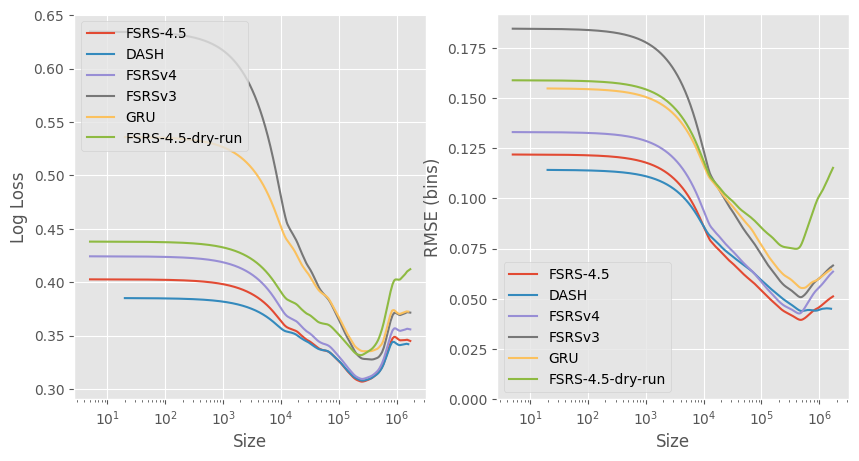

In [211]:
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

for model in ["FSRS-4.5", "DASH", "FSRSv4", "FSRSv3", "GRU", "FSRS-4.5-dry-run"]:
    print(model)
    metrics = []
    sizes = []
    users = []
    RMSE_list = []
    LogLoss_list = []
    result_dir = pathlib.Path(f"../result/{model}")
    result_files = list(result_dir.glob("*.json"))
    print("Num files:", len(result_files))
    for result_file in result_files:
        result = load_file(result_file)
        sizes.append(result["size"])
        users.append(result["user"])
        metrics.append(result["metrics"])
        RMSE_list.append(result["metrics"]["RMSE(bins)"])
        LogLoss_list.append(result["metrics"]["LogLoss"])

    log_loss, size = zip(*sorted(zip(LogLoss_list, sizes), key=lambda x: x[1]))
    log_loss = lowess(
        log_loss, size, it=0, is_sorted=True, return_sorted=False
    )
    ax1.plot(size, log_loss, label=model)
    rmse_bins, size = zip(*sorted(zip(RMSE_list, sizes), key=lambda x: x[1]))
    rmse_bins = lowess(
        rmse_bins, size, it=0, is_sorted=True, return_sorted=False
    )
    
    ax2.plot(size, rmse_bins, label=model)

ax1.semilogx()
ax2.semilogx()
ax1.legend()
ax2.legend()
ax1.set_xlabel("Size")
ax1.set_ylabel("Log Loss")
ax2.set_xlabel("Size")
ax2.set_ylim(bottom=0)
ax2.set_ylabel("RMSE (bins)")
plt.show()

Caching FSRS-4.5-fullinfo
Caching FSRS-4.5-dry-run-fullinfo
Caching FSRS-4.5-pretrain-fullinfo
FSRS-4.5-fullinfo
Num files: 1400
Num files used: 1400
FSRS-4.5-dry-run-fullinfo
Num files: 2040
Num files used: 1400
FSRS-4.5-pretrain-fullinfo
Num files: 2136
Num files used: 1400


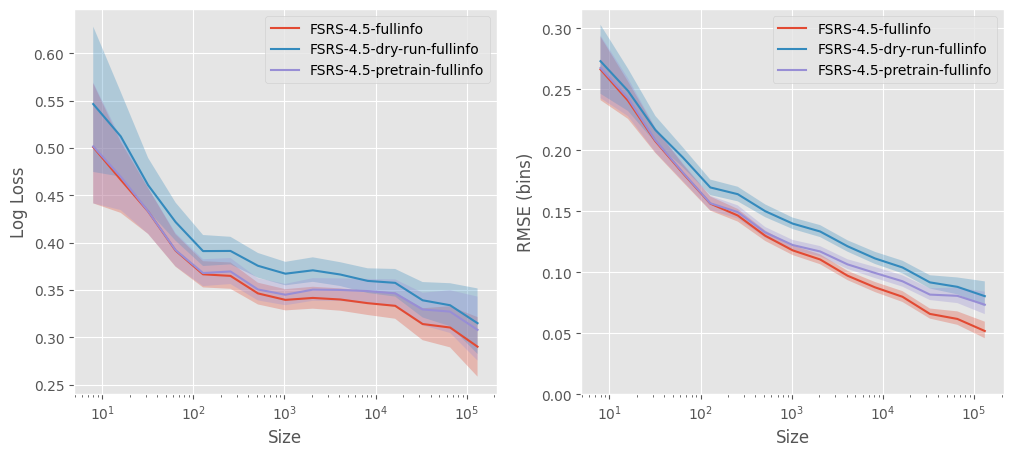

In [234]:
fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

# Get sizes where training worked for each file
sizes_train_worked_for_dict = {}
unique_sizes = set()
models = ["FSRS-4.5-fullinfo", "FSRS-4.5-dry-run-fullinfo", "FSRS-4.5-pretrain-fullinfo"]
for model in models:
    print("Caching", model)
    result_dir = pathlib.Path(f"../result/{model}")
    result_files = list(result_dir.glob("*.json"))
    for result_file in result_files:
        filename = result_file.name
        result = load_file(result_file)
        sizes = result["metrics"]["TrainSizes"]
        for s in sizes:
            if s not in unique_sizes:
                unique_sizes.add(s)
            k = (filename, s)
            if k not in sizes_train_worked_for_dict:
                sizes_train_worked_for_dict[k] = 0
            sizes_train_worked_for_dict[k] += 1
sizes_train_worked_for = {k for k,s in sizes_train_worked_for_dict.items() if s == len(models)}
unique_sizes = sorted(list(unique_sizes))

# Plot means & confidence intervals for each model
all_sizes = []
all_RMSE_list = []
all_LogLoss_list = []
all_RMSE_train_list = []
all_LogLoss_train_list = []
models = ["FSRS-4.5-fullinfo", "FSRS-4.5-dry-run-fullinfo", "FSRS-4.5-pretrain-fullinfo"]
for model in models:
    print(model)
    sizes = []
    RMSE_list = []
    LogLoss_list = []
    RMSE_train_list = []
    LogLoss_train_list = []
    result_dir = pathlib.Path(f"../result/{model}")
    result_files = list(result_dir.glob("*.json"))
    print("Num files:", len(result_files))
    if len(result_files) == 0:
        continue

    files_used = 0
    for result_file in result_files:
        file_used = False
        filename = result_file.name
        result = load_file(result_file)
        this_sizes, this_RMSE_list, this_LogLoss_list, this_RMSE_train_list, this_LogLoss_train_list = result["metrics"]["TrainSizes"], result["metrics"]["RMSE(bins)"], result["metrics"]["LogLoss"], result["metrics"]["RMSE(bins)Train"], result["metrics"]["LogLossTrain"]
        i_to_keep = []
        for i,s in enumerate(this_sizes):
            if (filename, s) in sizes_train_worked_for:
                i_to_keep.append(i)
                file_used = True
        sizes.extend([this_sizes[i] for i in i_to_keep])
        RMSE_list.extend([this_RMSE_list[i] for i in i_to_keep])
        LogLoss_list.extend([this_LogLoss_list[i] for i in i_to_keep])
        RMSE_train_list.extend([this_RMSE_train_list[i] for i in i_to_keep])
        LogLoss_train_list.extend([this_LogLoss_train_list[i] for i in i_to_keep])
        
        if file_used:
            files_used += 1
    print("Num files used:", files_used)
    if len(sizes) == 0:
        continue
    
    all_sizes.append(sizes)
    all_RMSE_list.append(RMSE_list)
    all_LogLoss_list.append(LogLoss_list)
    all_RMSE_train_list.append(RMSE_train_list)
    all_LogLoss_train_list.append(LogLoss_train_list)

    for this_losses, ax in zip([LogLoss_list, RMSE_list], [ax1, ax2]):
        # Get loss bins for each number of reviews known (called size)
        log_loss, size = zip(*sorted(zip(this_losses, sizes), key=lambda x: x[1]))
        log_loss = np.array(log_loss)
        size = np.array(size)
        size_unique = np.unique(size)
        log_loss_bins = [log_loss[size == s] for s in size_unique]

        # Remove any bins with less than 50 samples
        size_unique = [s for s, l in zip(size_unique, log_loss_bins) if len(l) >= 50]
        log_loss_bins = [l for l in log_loss_bins if len(l) >= 50]

        # Calculate 95% CI for each bin
        log_loss_bins_ci = [bootstrap((l,), np.mean, confidence_level=0.95, method="BCa").confidence_interval for l in log_loss_bins]

        # Plot means
        log_loss_means = [np.mean(l) for l in log_loss_bins]
        if len(size_unique) == 0: continue
        ax.plot(size_unique, log_loss_means, label=model)

        # Shade between confidence intervals
        log_loss_low = [l[0] for l in log_loss_bins_ci]
        log_loss_high = [l[1] for l in log_loss_bins_ci]
        ax.fill_between(size_unique, log_loss_low, log_loss_high, alpha=0.3)  #type: ignore

ax1.semilogx()
ax2.semilogx()
ax1.legend()
ax2.legend()
ax1.set_xlabel("Size")
ax1.set_ylabel("Log Loss")
ax2.set_xlabel("Size")
ax2.set_ylim(bottom=0)
ax2.set_ylabel("RMSE (bins)")
plt.show()


To explain the graphs below:
Size 16: This is for 16 reviews being done in the past.
For the first 2 graphs, plotting the optimised FSRS loss on y-axis, unoptimised FSRS on x-axis. If the points are lower than the y=x dotted line, optimised FSRS did better. Above the y=x dotted line means default FSRS did better.
You can see that if default FSRS has high loss, it's better to optimise it (at least when size is low, for high sizes it's best to always optimise)
The vertical dotted line is the best choice for when to switch to optimised FSRS (0.3 would mean when default FSRS loss > 0.3, use optimised FSRS)
The third and fourth graph show how the choice of v (the loss at which to switch to optimised FSRS) affects the loss.
Note: It would be more accurate to use a second testing set to determine if a low default FSRS loss indicates optimised FSRS will do worse.



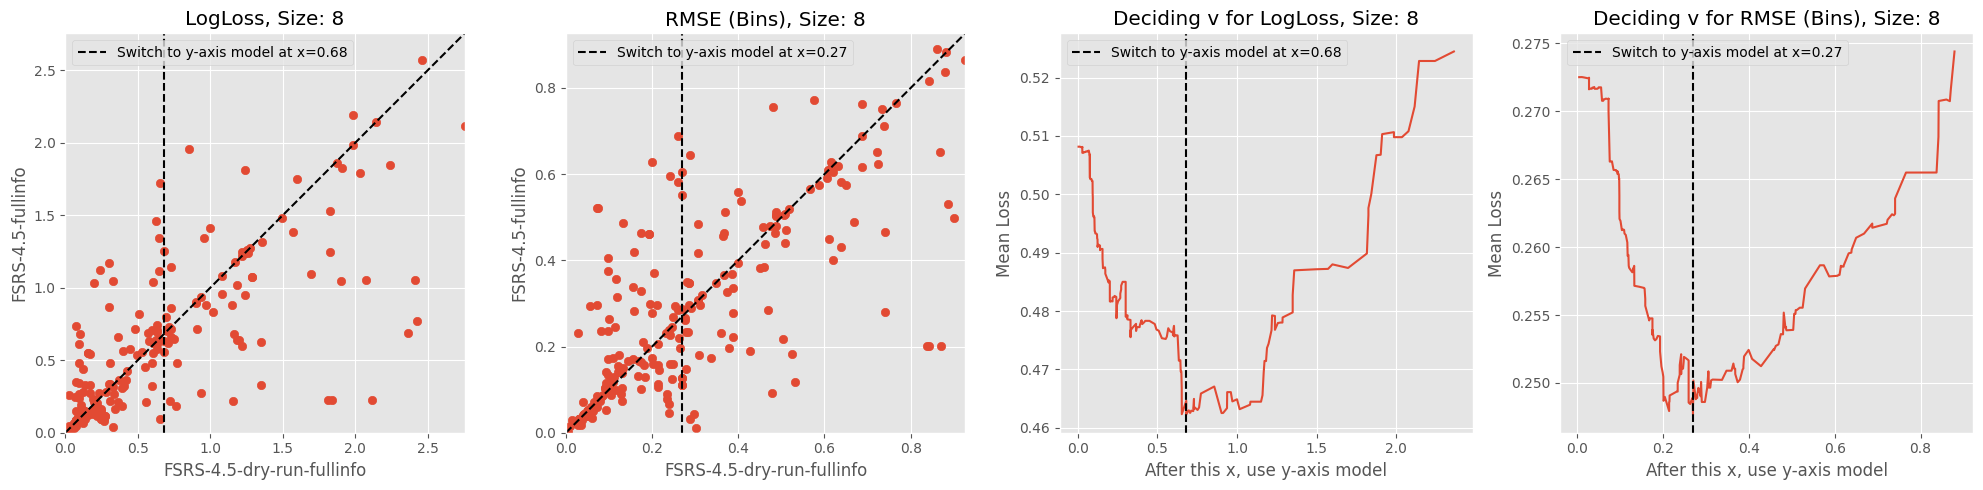

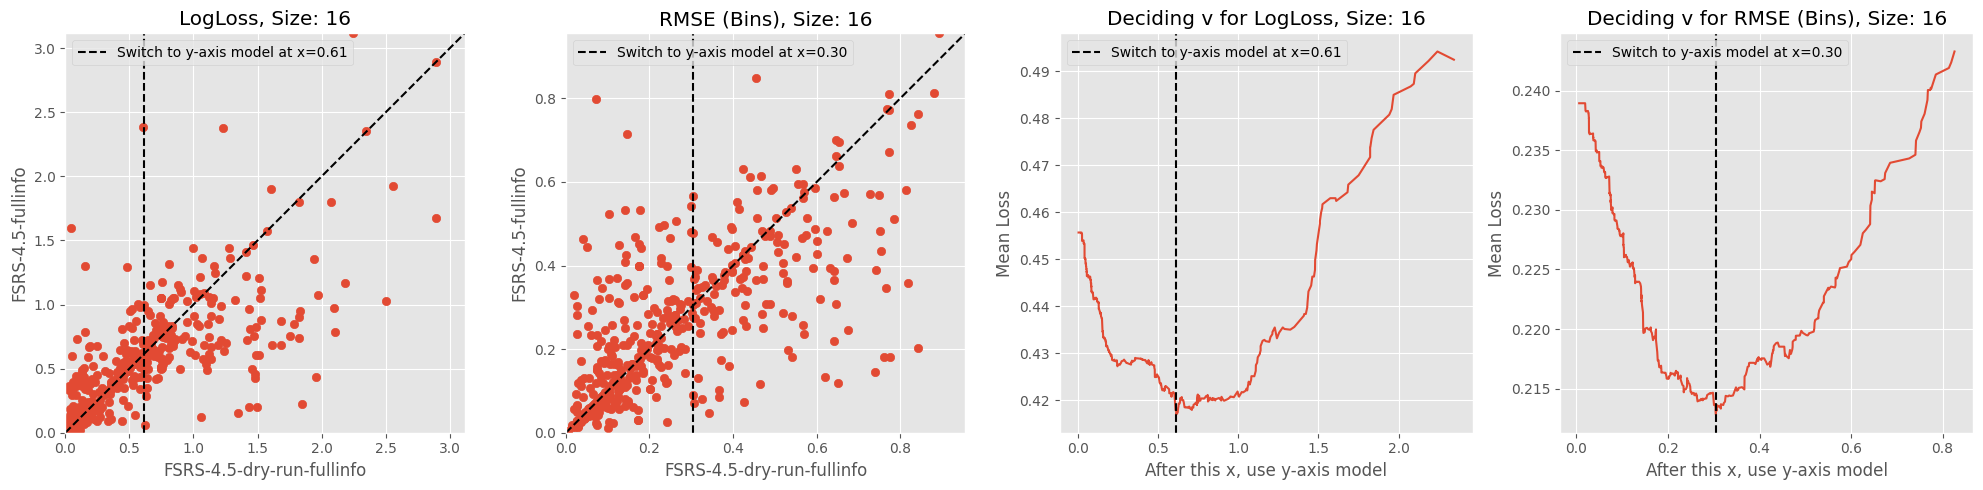

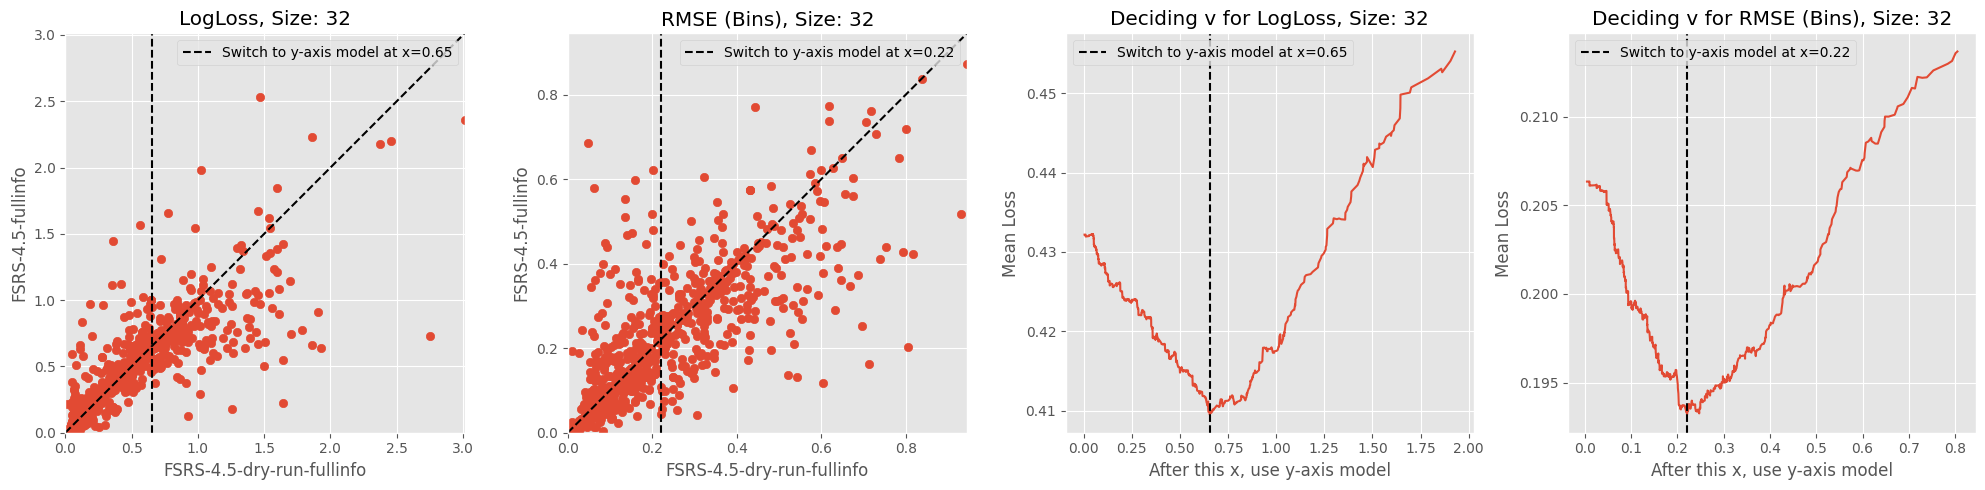

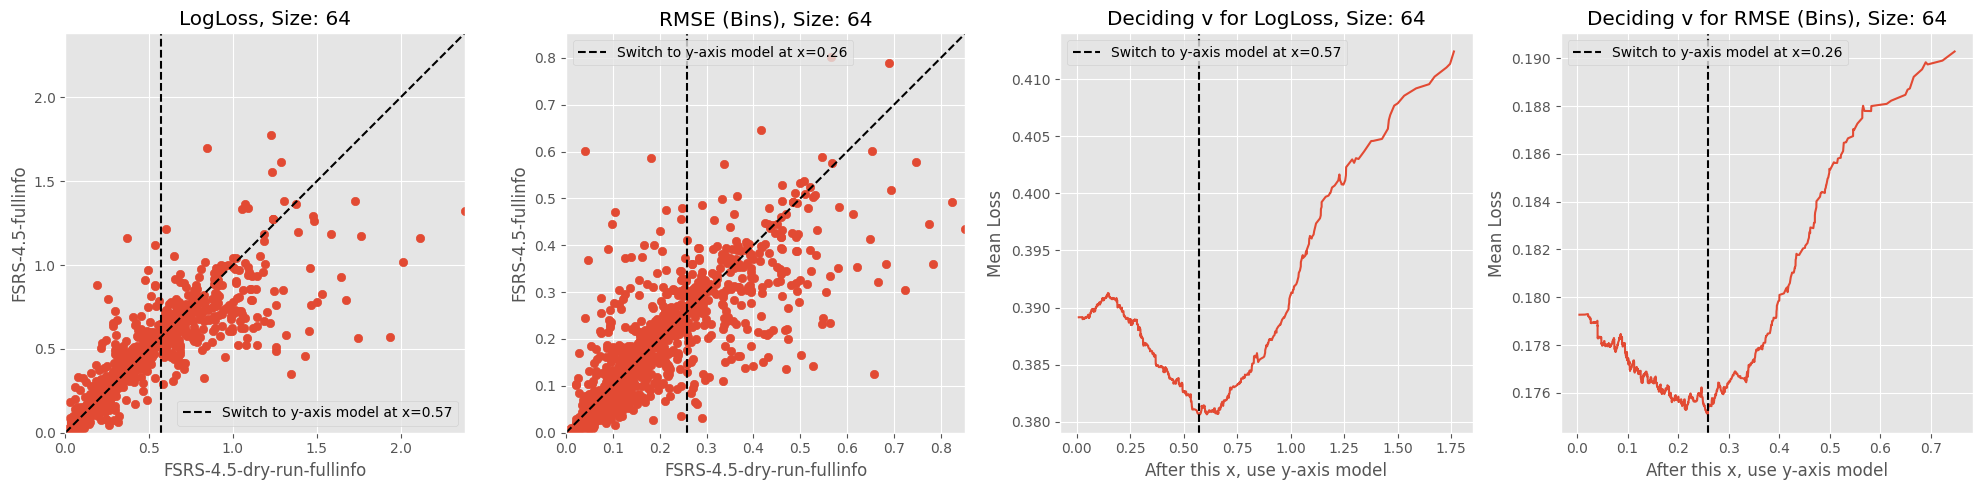

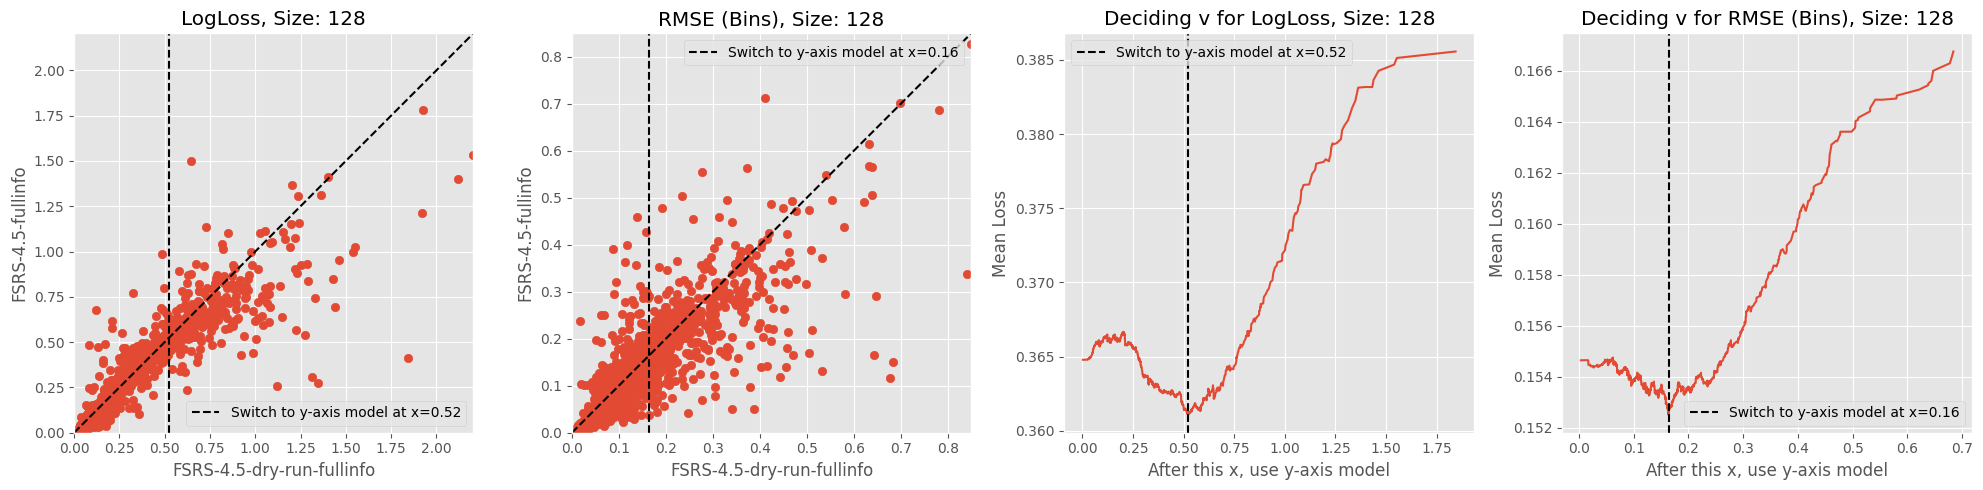

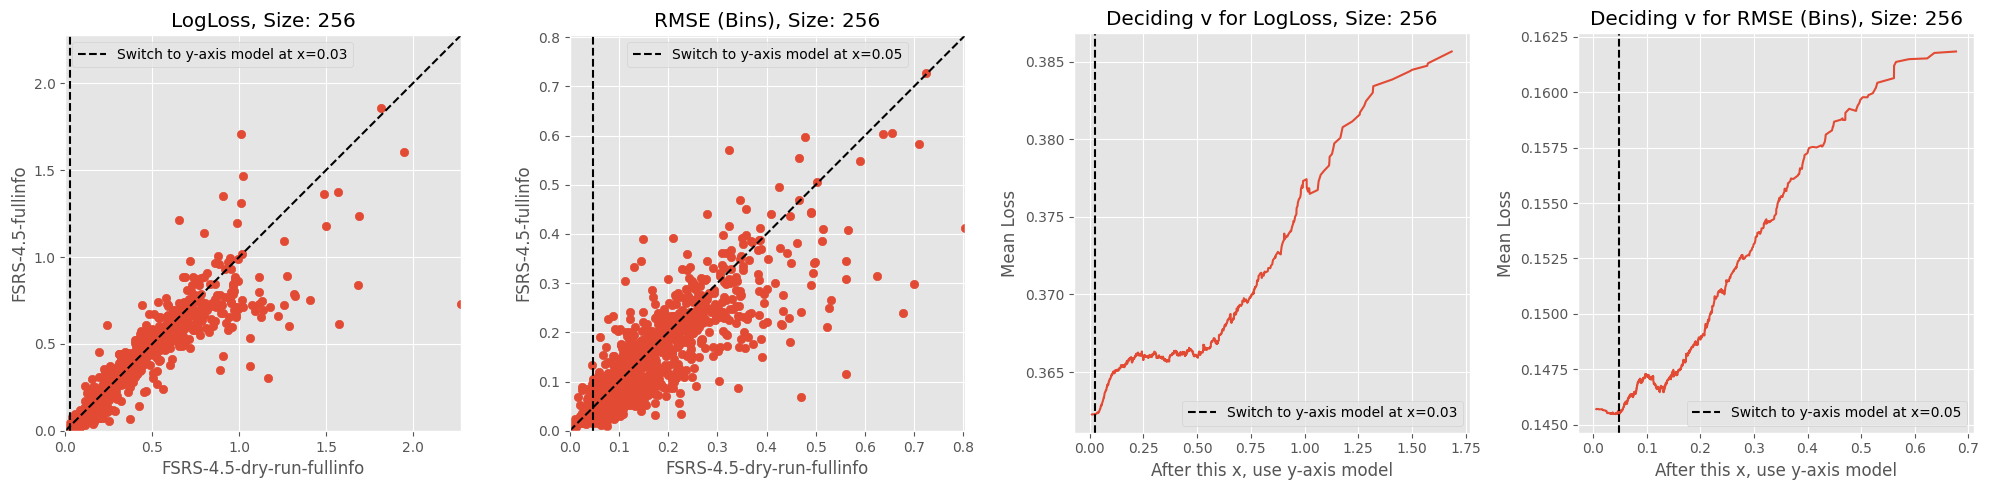

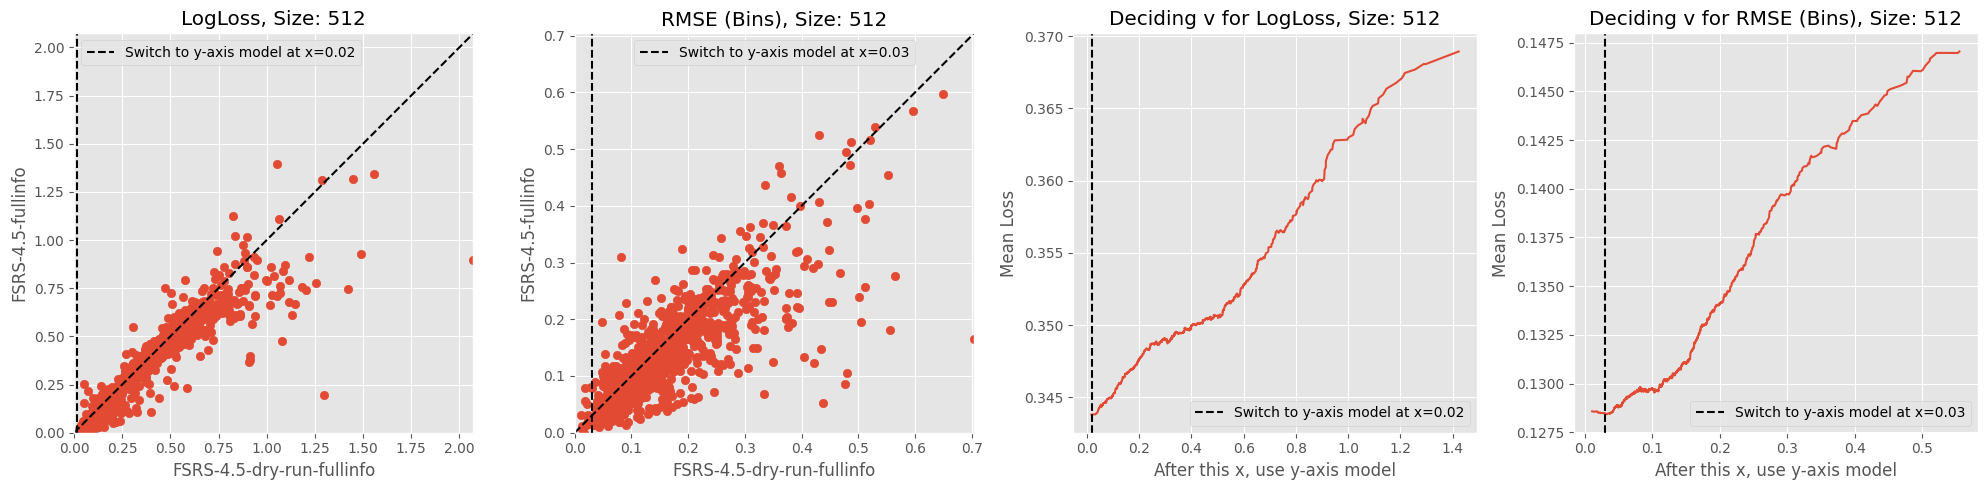

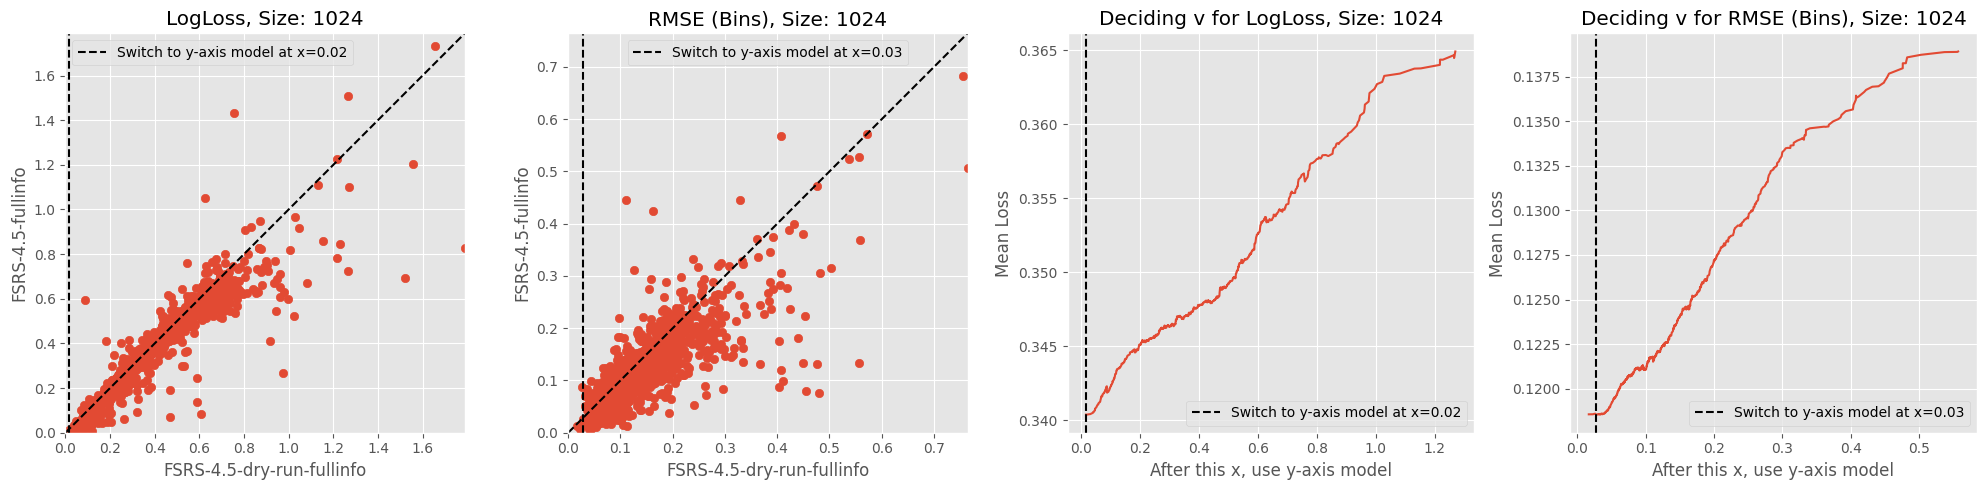

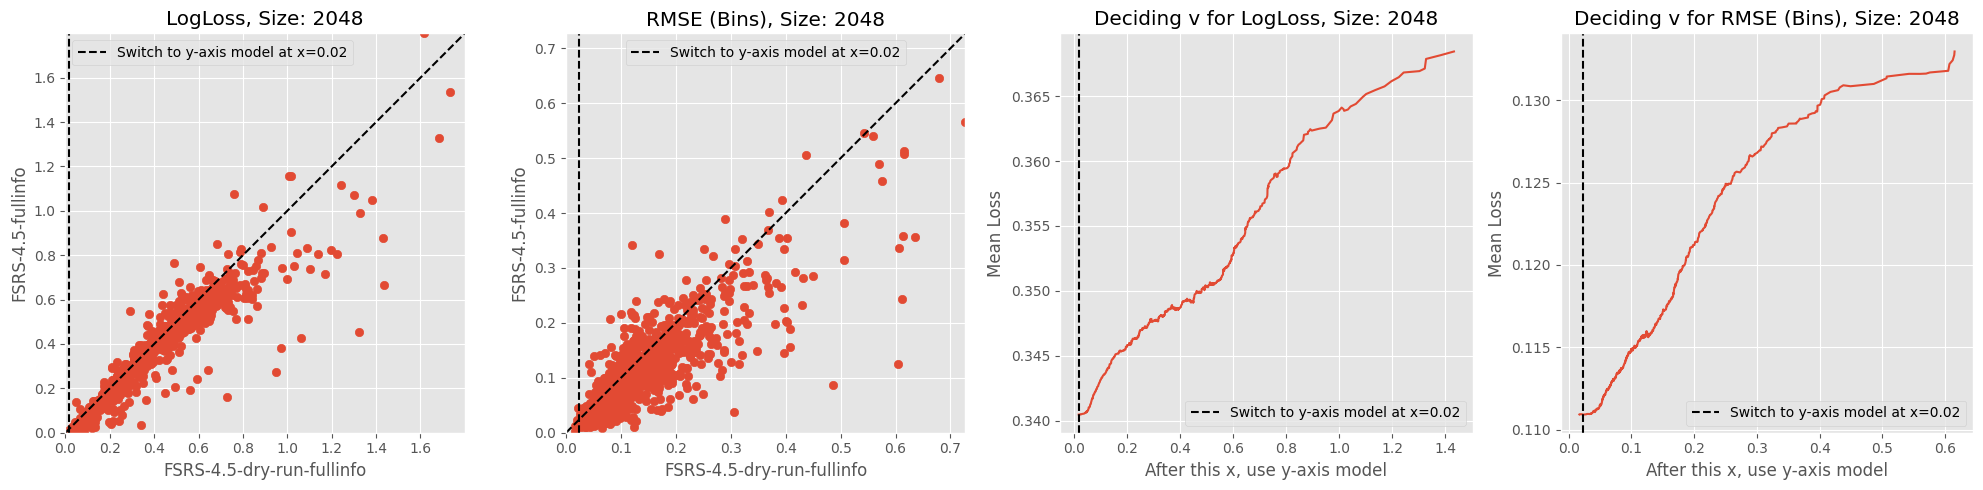

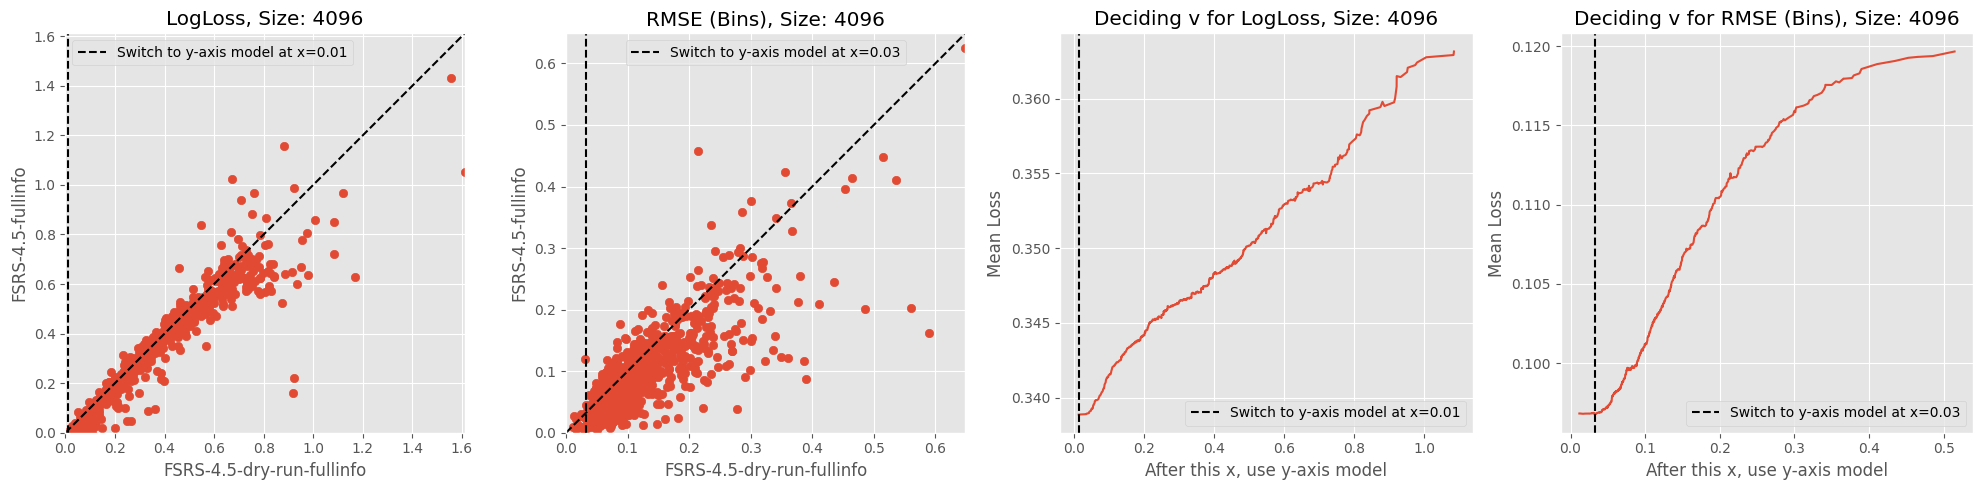

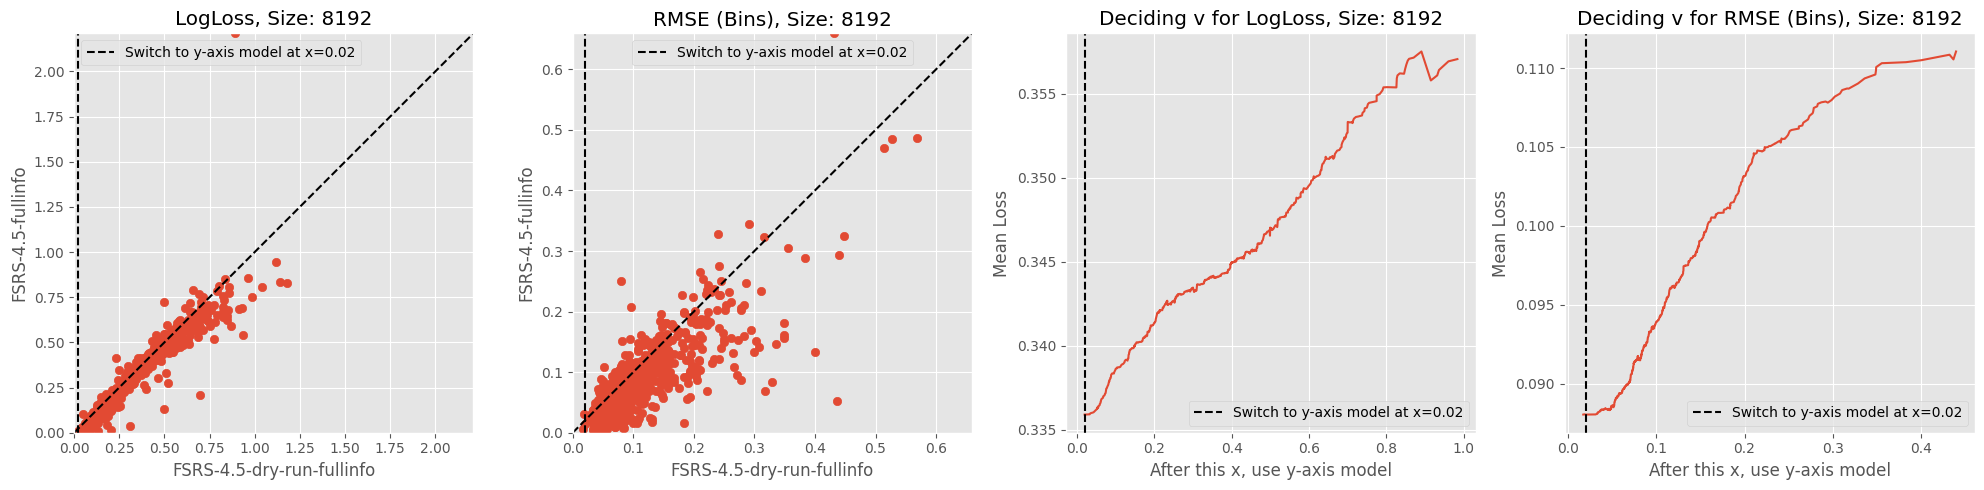

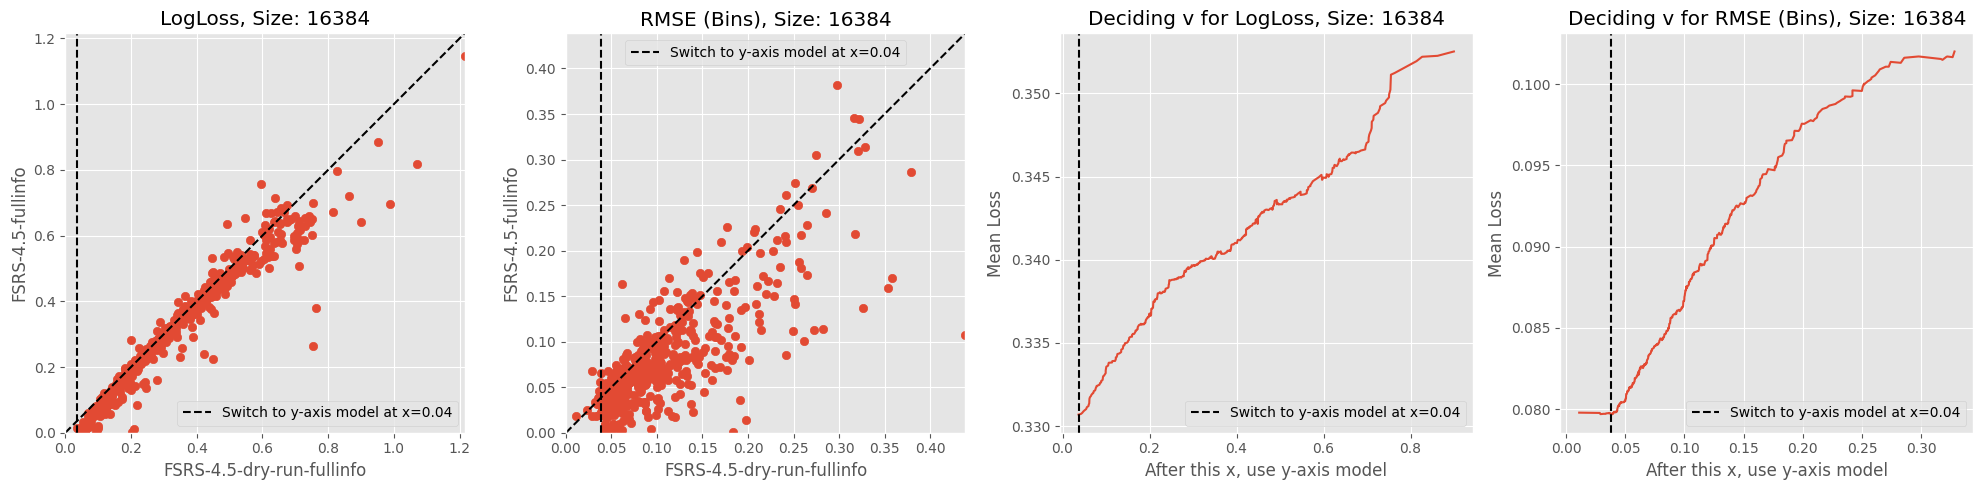

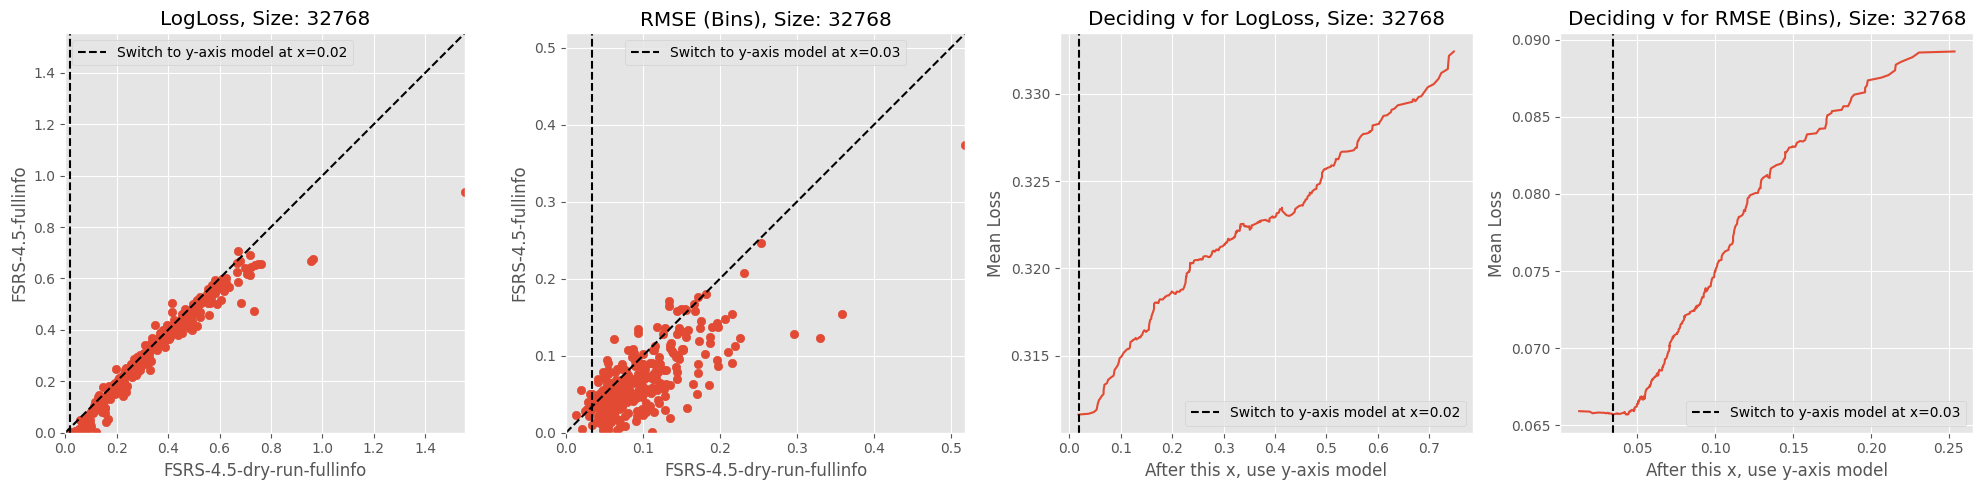

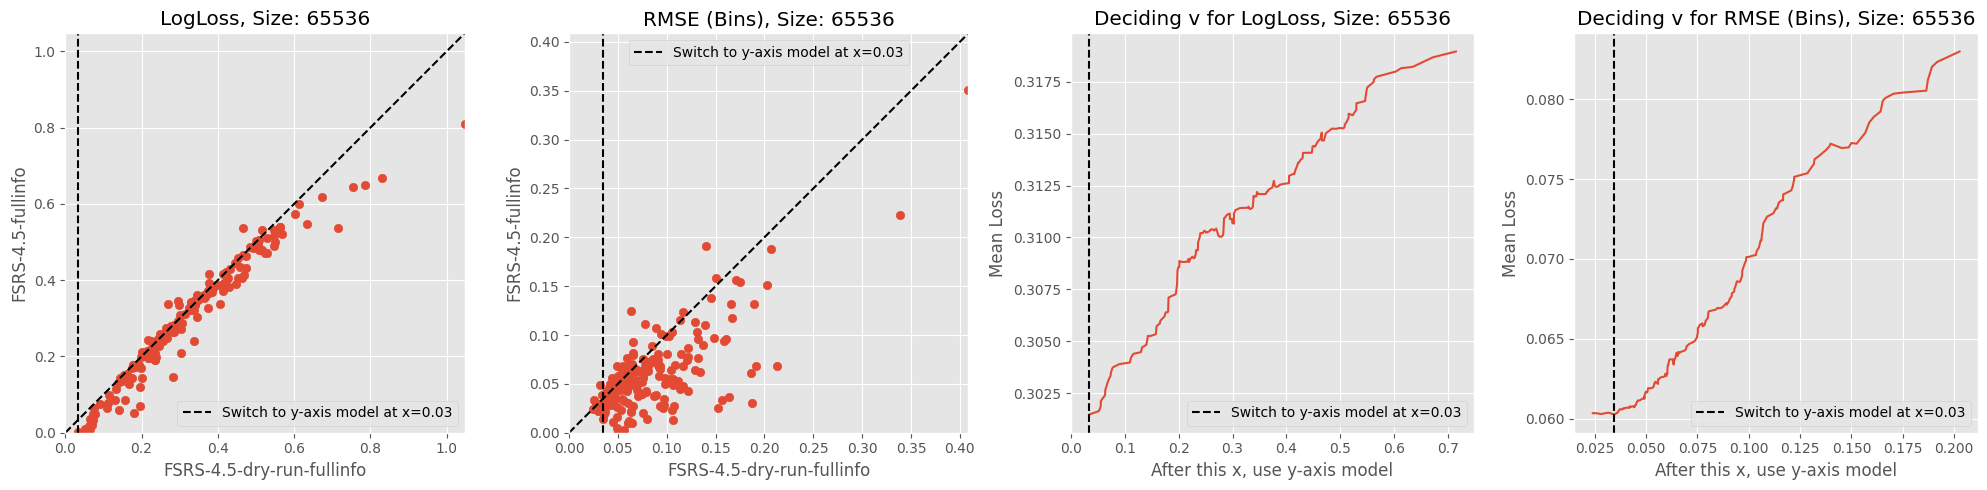

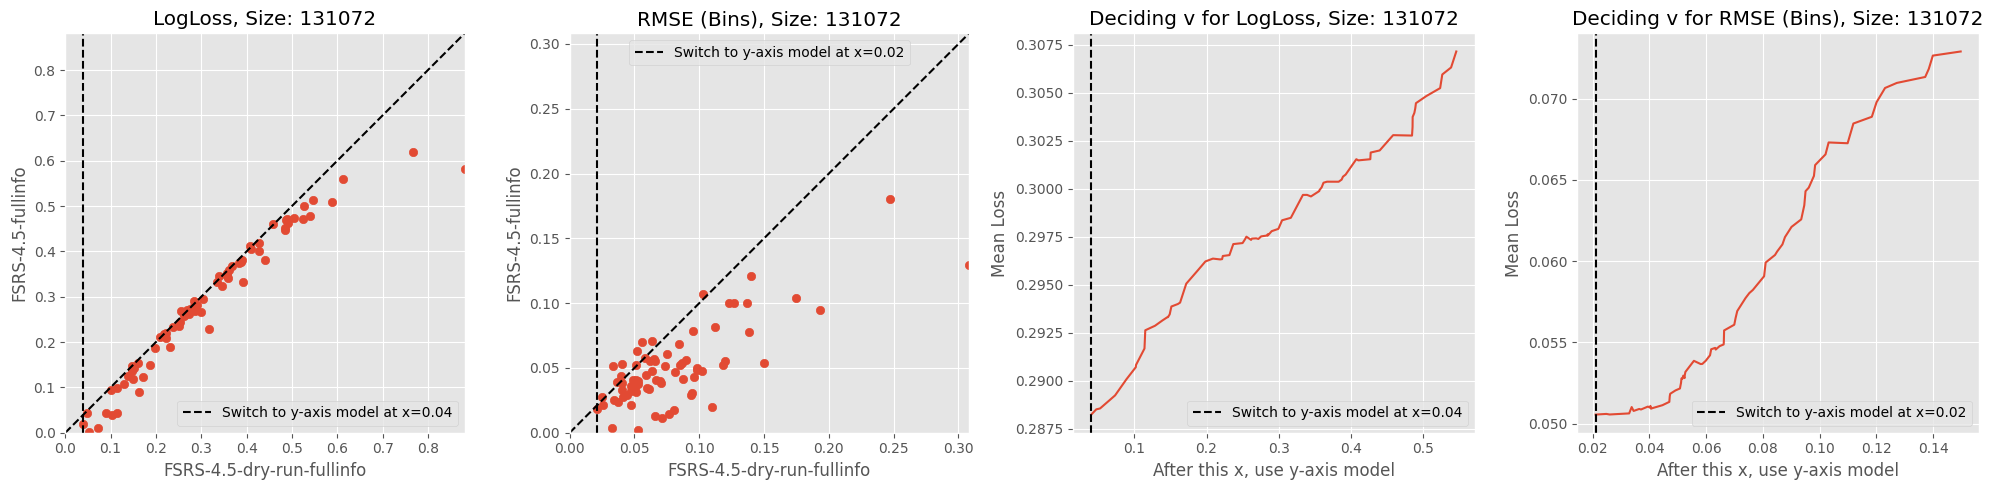

In [228]:
print("""
To explain the graphs below:
Size 16: This is for 16 reviews being done in the past.
For the first 2 graphs, plotting the optimised FSRS loss on y-axis, unoptimised FSRS on x-axis. If the points are lower than the y=x dotted line, optimised FSRS did better. Above the y=x dotted line means default FSRS did better.
You can see that if default FSRS has high loss, it's better to optimise it (at least when size is low, for high sizes it's best to always optimise)
The vertical dotted line is the best choice for when to switch to optimised FSRS (0.3 would mean when default FSRS loss > 0.3, use optimised FSRS)
The third and fourth graph show how the choice of v (the loss at which to switch to optimised FSRS) affects the loss.
Note: It would be more accurate to use a second testing set to determine if a low default FSRS loss indicates optimised FSRS will do worse.
""")

# Plot all_RMSE_list[0] against all_RMSE_list[1] for each size (each size is a new graph)
model_x_index = 1  # Will find v where, after x=v, model_y does better than model_x
model_y_index = 0
for size in unique_sizes:
    RMSE_list_x = [x for x,s in zip(all_RMSE_list[model_x_index], all_sizes[model_x_index]) if s == size]
    RMSE_list_y = [y for y,s in zip(all_RMSE_list[model_y_index], all_sizes[model_y_index]) if s == size]
    LogLoss_list_x = [x for x,s in zip(all_LogLoss_list[model_x_index], all_sizes[model_x_index]) if s == size]
    LogLoss_list_y = [y for y,s in zip(all_LogLoss_list[model_y_index], all_sizes[model_y_index]) if s == size]

    # Must be at least 50 samples for each model
    if len(RMSE_list_x) < 50 or len(RMSE_list_y) < 50:
        continue
    num_pts = min(len(RMSE_list_x), len(RMSE_list_y))
    RMSE_list_x = RMSE_list_x[:num_pts]
    RMSE_list_y = RMSE_list_y[:num_pts]
    LogLoss_list_x = LogLoss_list_x[:num_pts]
    LogLoss_list_y = LogLoss_list_y[:num_pts]

    # Sort by x
    RMSE_list_x, RMSE_list_y = zip(*sorted(zip(RMSE_list_x, RMSE_list_y), key=lambda x: x[0]))
    LogLoss_list_x, LogLoss_list_y = zip(*sorted(zip(LogLoss_list_x, LogLoss_list_y), key=lambda x: x[0]))

    # Scatter plot
    fig = plt.figure(figsize=(20, 5))
    ax1 = fig.add_subplot(141)
    ax2 = fig.add_subplot(142)
    ax3 = fig.add_subplot(143)
    ax4 = fig.add_subplot(144)
    ax1.scatter(LogLoss_list_x, LogLoss_list_y)
    ax2.scatter(RMSE_list_x, RMSE_list_y)

    # For each x point, get the y points after that and plot (x, mean y) and the confidence interval of y
    all_v_logloss, all_y_logloss = [], []
    all_v_rmse, all_y_rmse = [], []
    for i in range(len(LogLoss_list_x)):
        v = LogLoss_list_x[i]
        losses_before = LogLoss_list_x[:i]
        losses_after = LogLoss_list_y[i:]
        losses = losses_before + losses_after
        if len(losses_after) >= 5:
            all_v_logloss.append(v)
            all_y_logloss.append(np.mean(losses))
    for i in range(len(RMSE_list_x)):
        v = RMSE_list_x[i]
        losses_before = RMSE_list_x[:i]
        losses_after = RMSE_list_y[i:]
        losses = losses_before + losses_after
        if len(losses_after) >= 5:
            all_v_rmse.append(v)
            all_y_rmse.append(np.mean(losses))

    # Get the best v (at minimum y)
    best_v_logloss = all_v_logloss[np.argmin(all_y_logloss)]
    best_v_rmse = all_v_rmse[np.argmin(all_y_rmse)]

    # Plot on ax3 snd ax4 the loss for a given value v
    ax3.plot(all_v_logloss, all_y_logloss)
    ax4.plot(all_v_rmse, all_y_rmse)

    # Draw dotted black vertical line at best v
    ax1.axvline(best_v_logloss, color="black", linestyle="--", label=f"Switch to y-axis model at x={best_v_logloss:.2f}")
    ax2.axvline(best_v_rmse, color="black", linestyle="--", label=f"Switch to y-axis model at x={best_v_rmse:.2f}")
    ax3.axvline(best_v_logloss, color="black", linestyle="--", label=f"Switch to y-axis model at x={best_v_logloss:.2f}")
    ax4.axvline(best_v_rmse, color="black", linestyle="--", label=f"Switch to y-axis model at x={best_v_rmse:.2f}")

    # Draw dotted line for x=y
    max_log_loss = max(max(LogLoss_list_x), max(LogLoss_list_y))
    max_rmse_loss = max(max(RMSE_list_x), max(RMSE_list_y))
    ax1.plot([0, max_log_loss], [0, max_log_loss], "k--")
    ax2.plot([0, max_rmse_loss], [0, max_rmse_loss], "k--")

    # Format and display
    ax1.set_title(f"LogLoss, Size: {size}")
    ax2.set_title(f"RMSE (Bins), Size: {size}")
    ax3.set_title(f"Deciding v for LogLoss, Size: {size}")
    ax4.set_title(f"Deciding v for RMSE (Bins), Size: {size}")
    ax1.set_xlabel(models[model_x_index])
    ax1.set_ylabel(models[model_y_index])
    ax2.set_xlabel(models[model_x_index])
    ax2.set_ylabel(models[model_y_index])
    ax3.set_xlabel("After this x, use y-axis model")
    ax3.set_ylabel("Mean Loss")
    ax4.set_xlabel("After this x, use y-axis model")
    ax4.set_ylabel("Mean Loss")
    ax1.set_xlim(0, max_log_loss)
    ax1.set_ylim(0, max_log_loss)
    ax2.set_xlim(0, max_rmse_loss)
    ax2.set_ylim(0, max_rmse_loss)
    # Ensure aspect ratio is 1:1
    ax1.set_aspect("equal", adjustable="box")
    ax2.set_aspect("equal", adjustable="box")
    ax1.legend()
    ax2.legend()
    ax3.legend()
    ax4.legend()
    plt.tight_layout()
    plt.show()



For the graphs below:
X-axis: How much better the loss is than default on train
Y-axis: How much better the loss is than default on test

Top right: The optimised model is better on train and test
Bottom right: The optimised model is better on train but worse on test
Top left: The optimised model is worse on train but better on test
Bottom left: The optimised model is worse on train and test



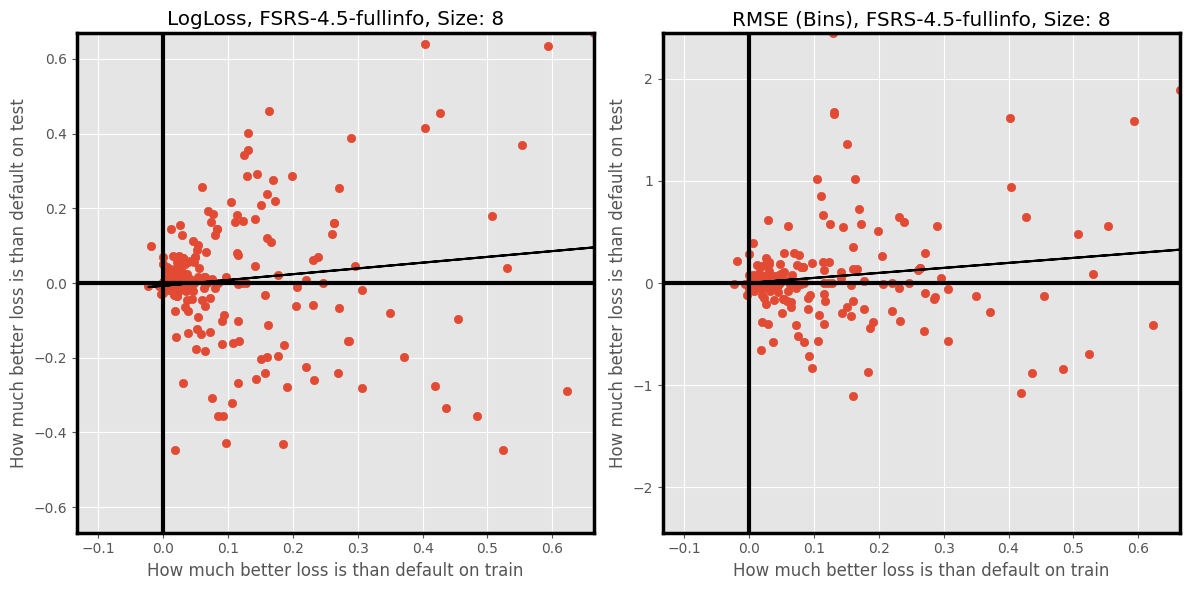

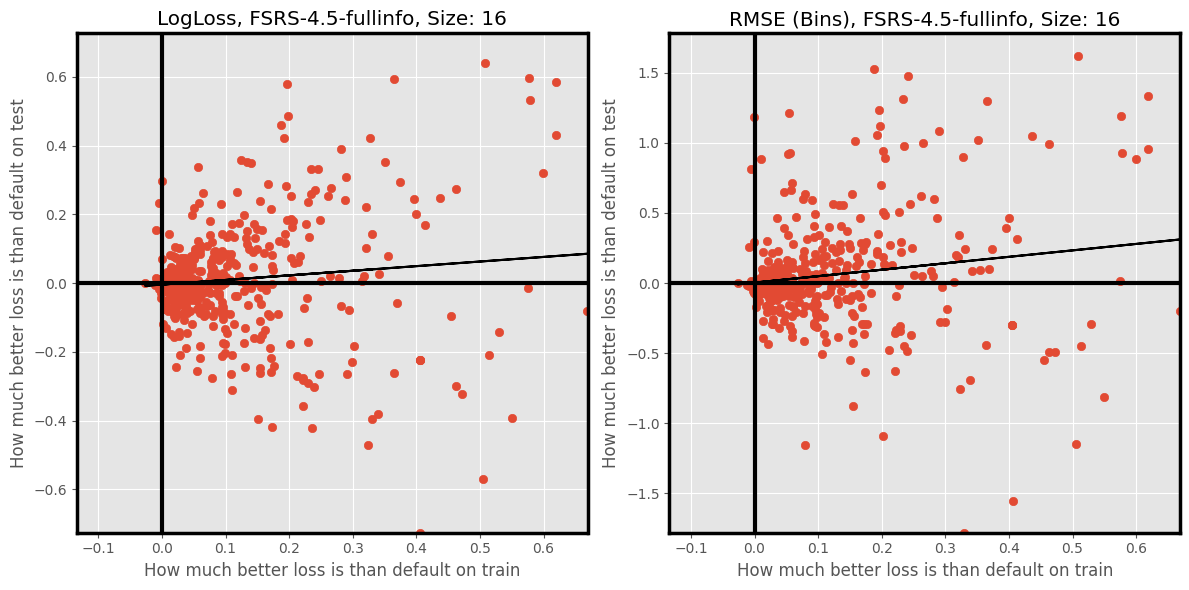

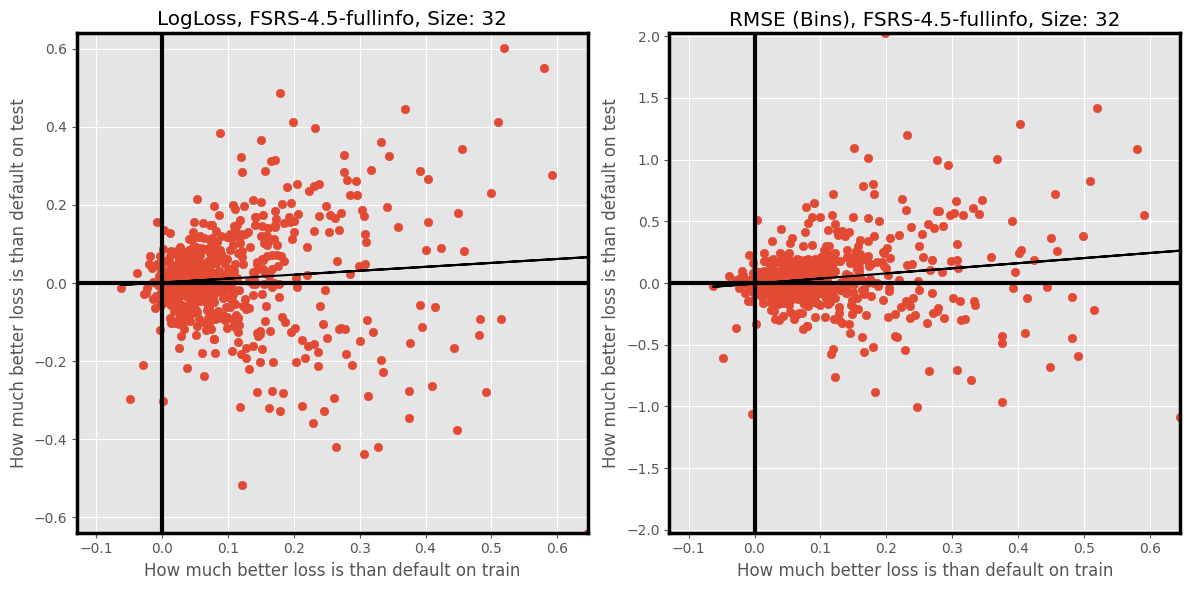

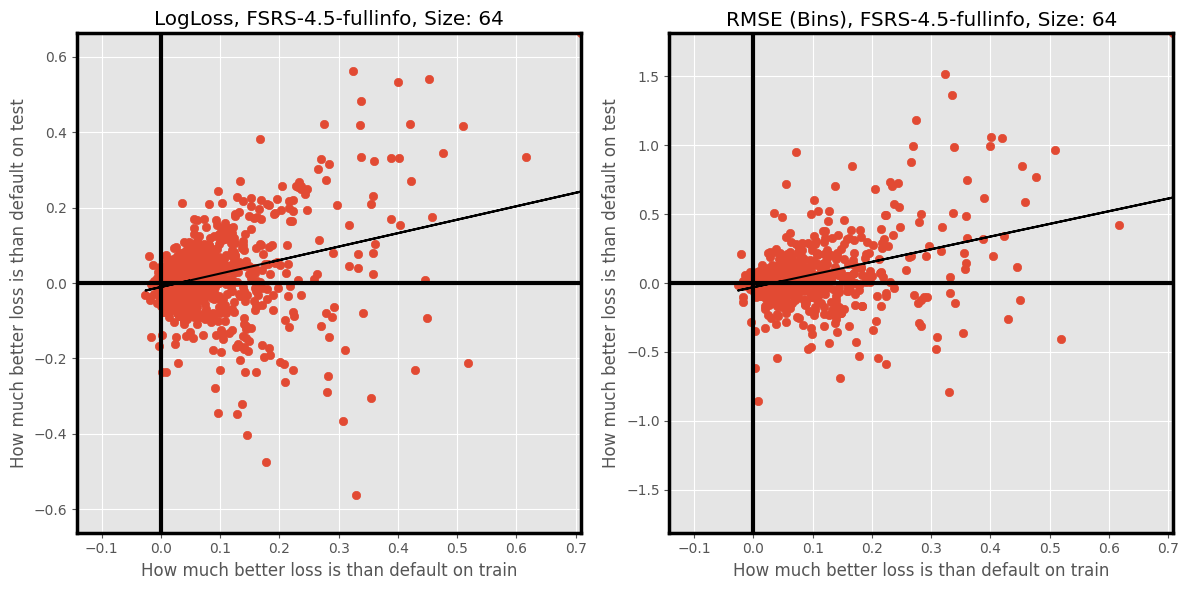

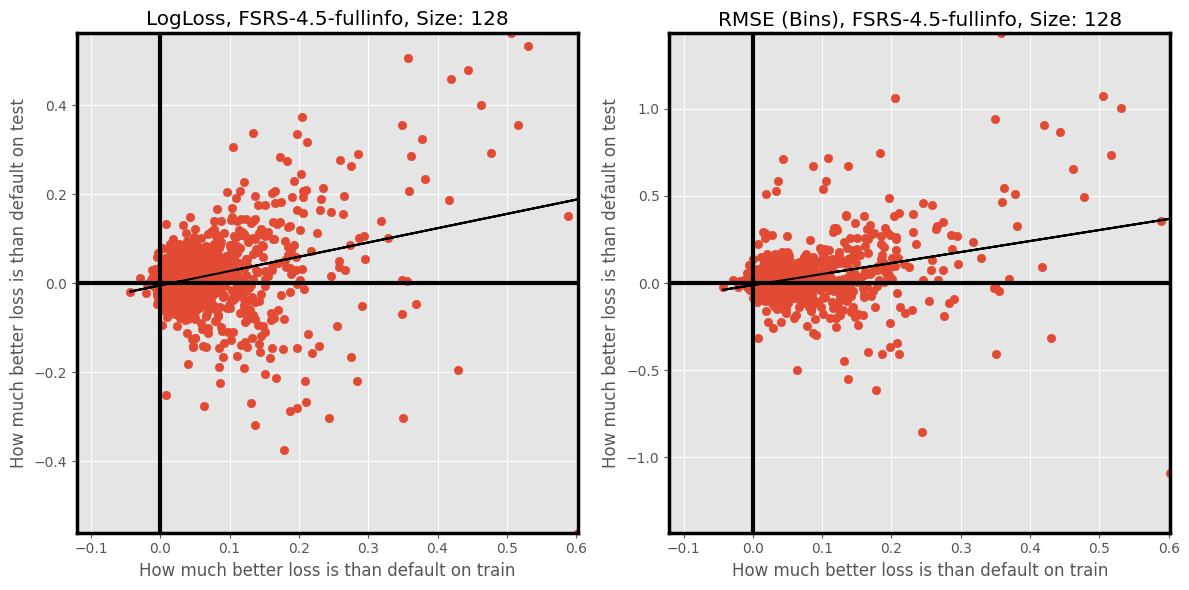

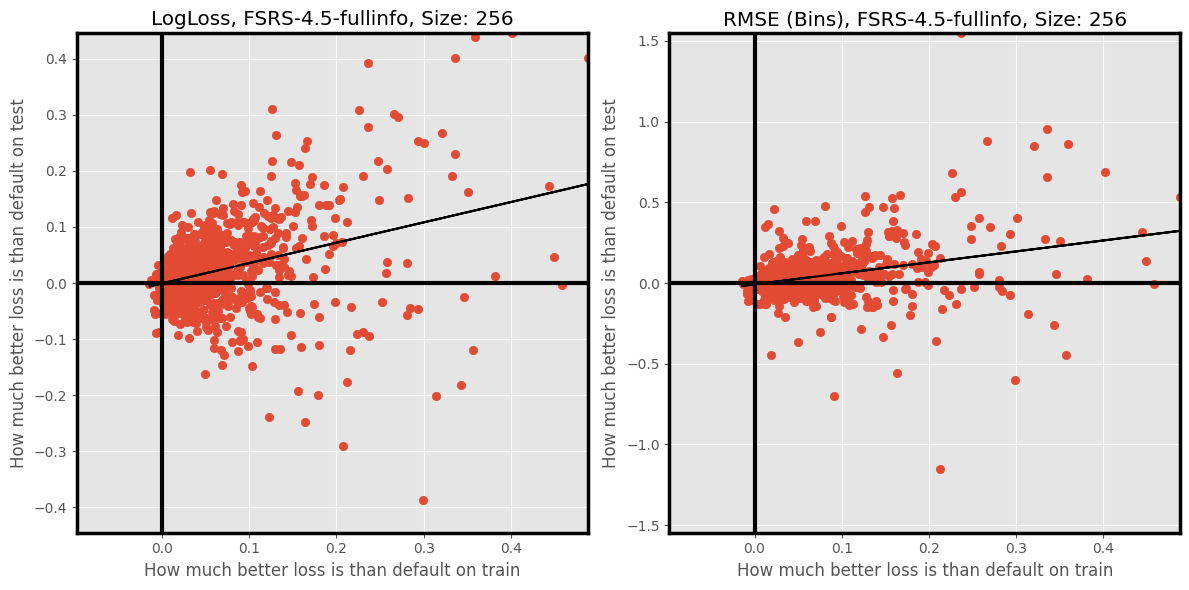

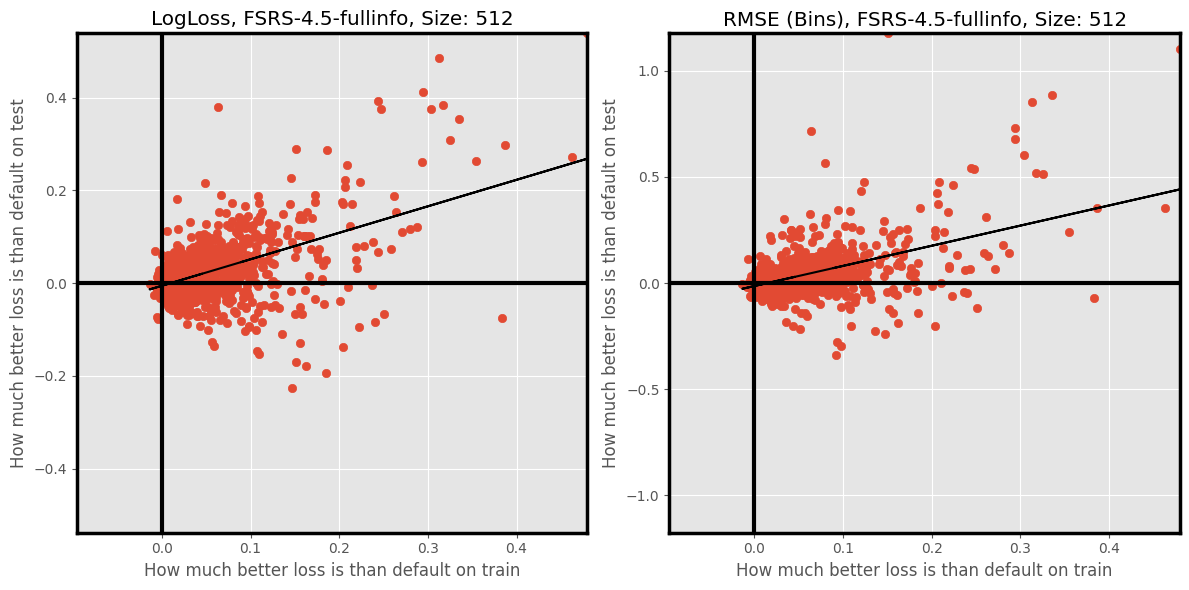

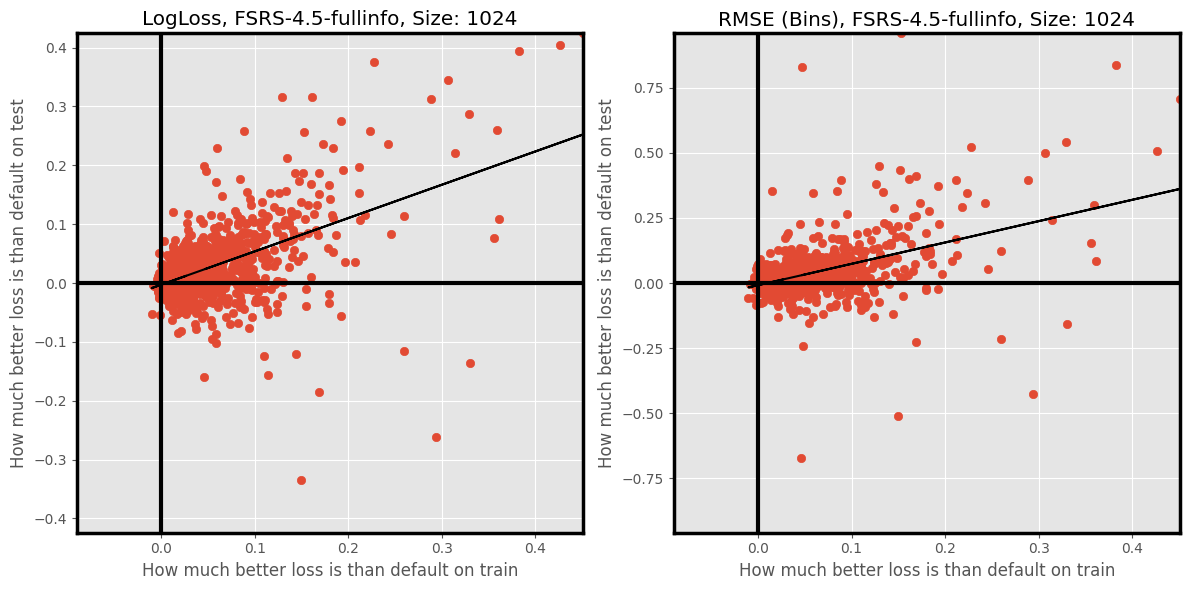

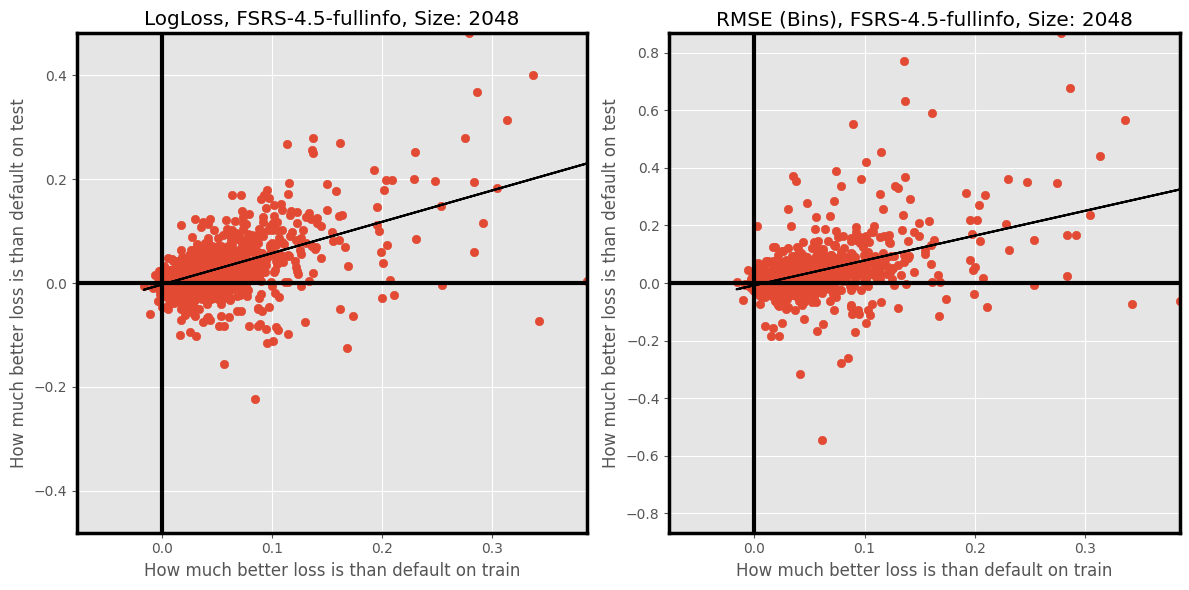

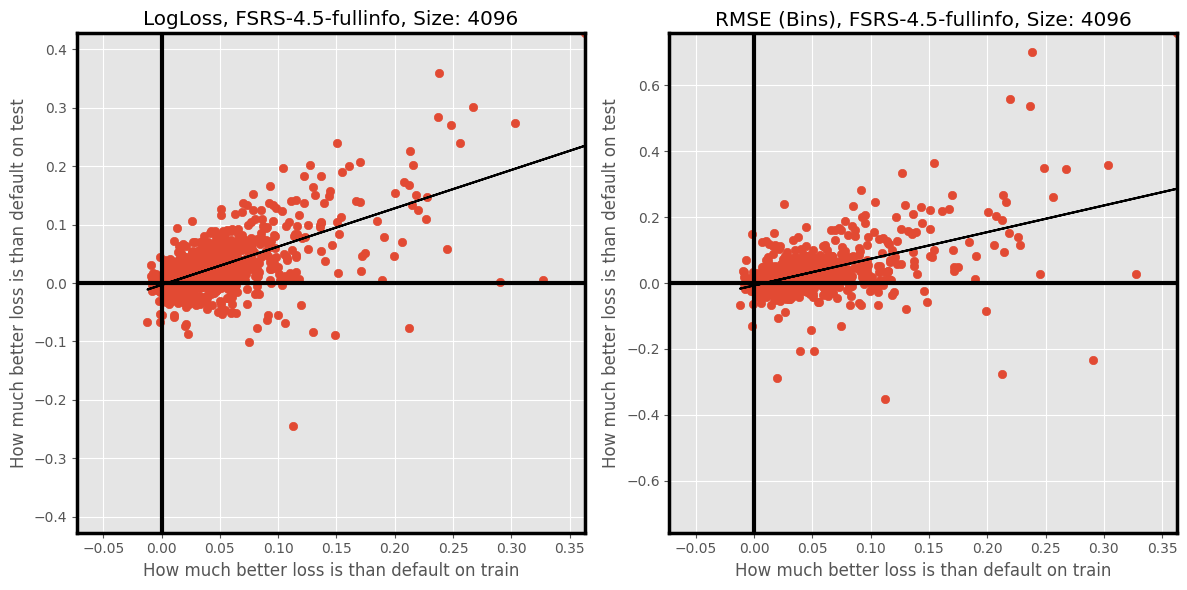

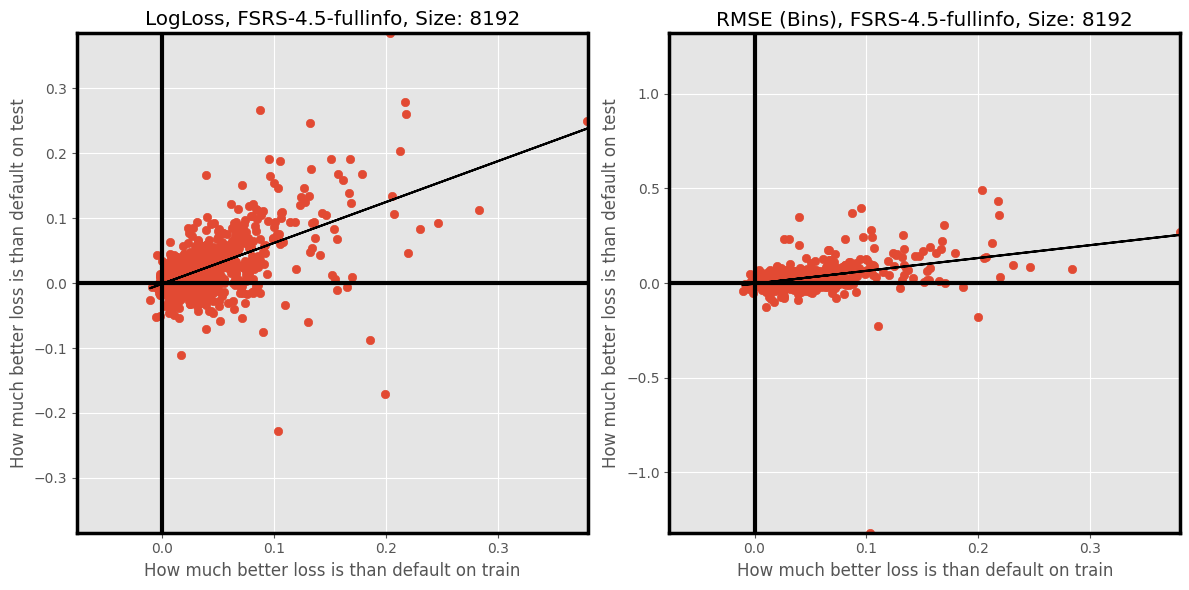

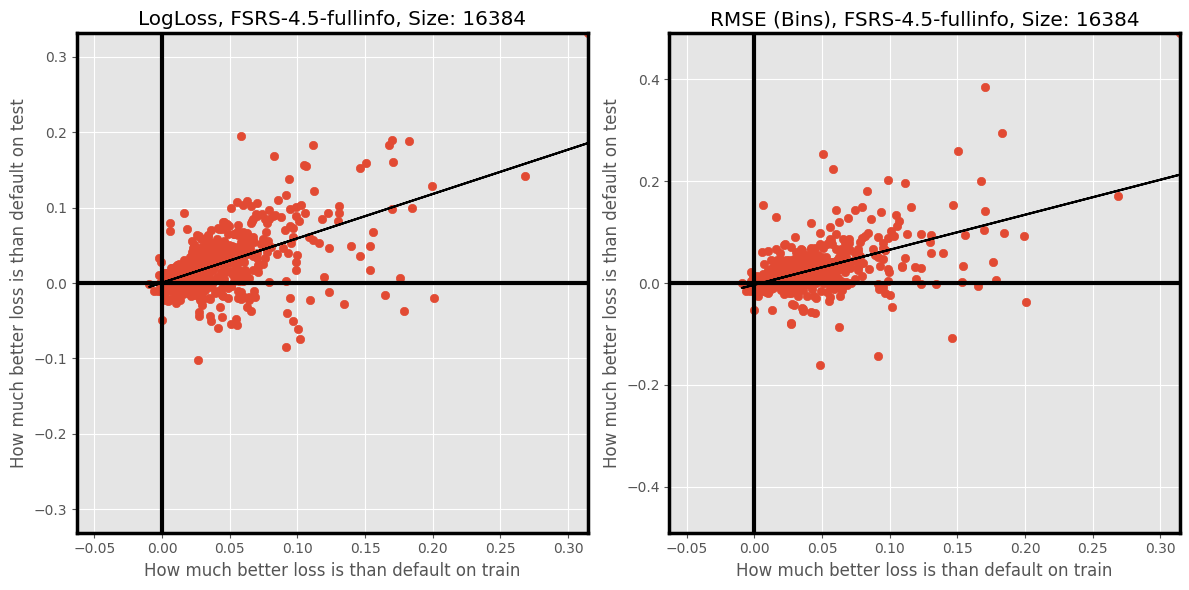

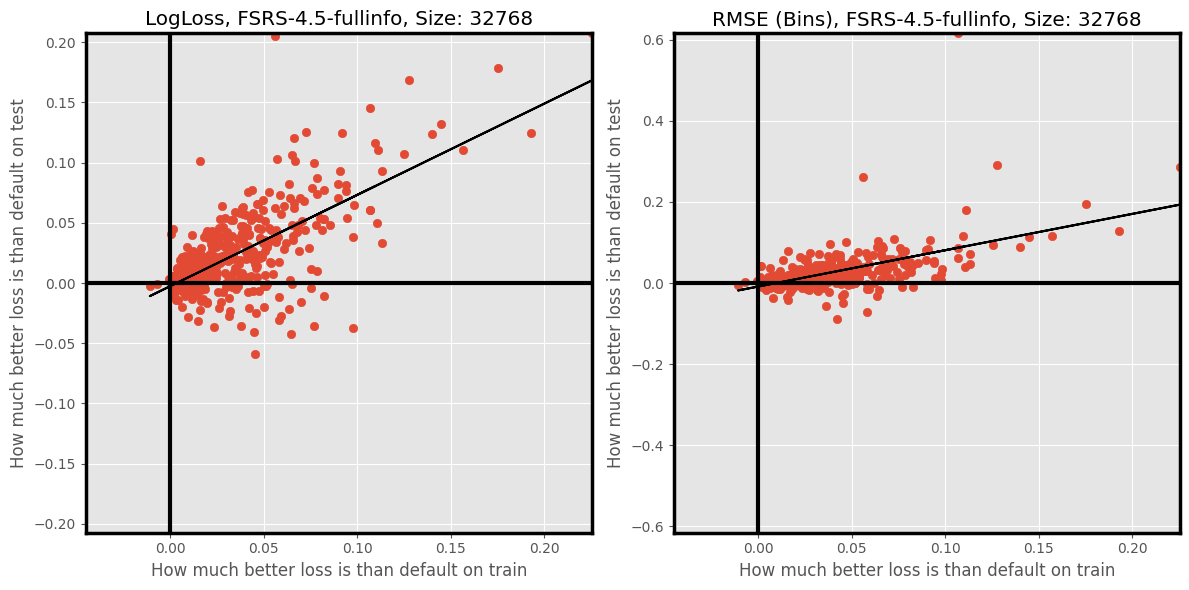

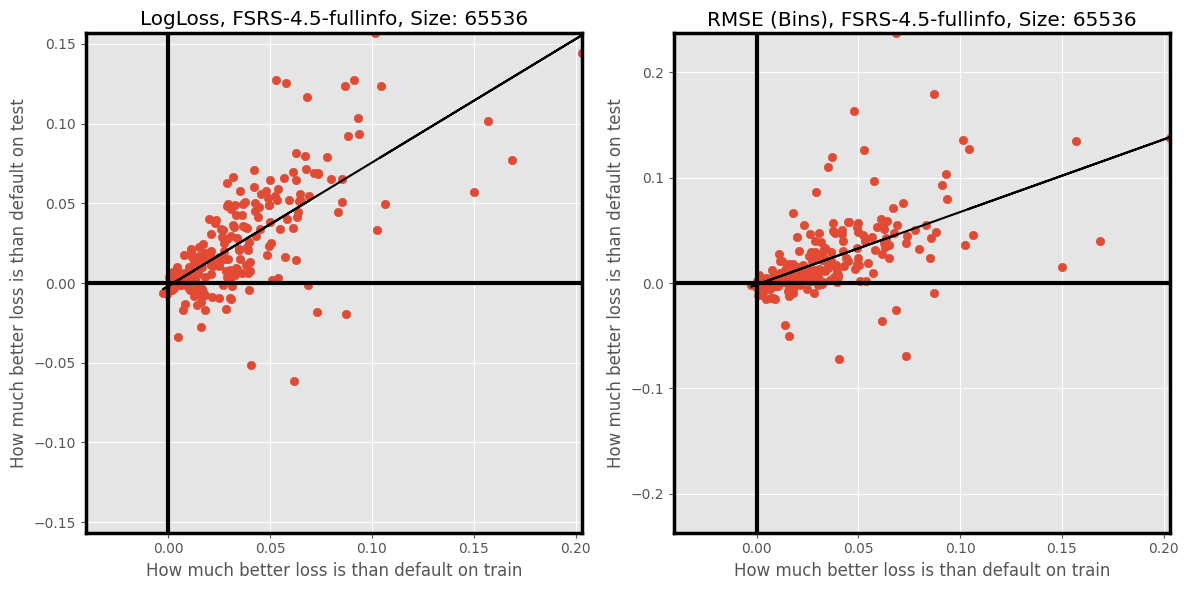

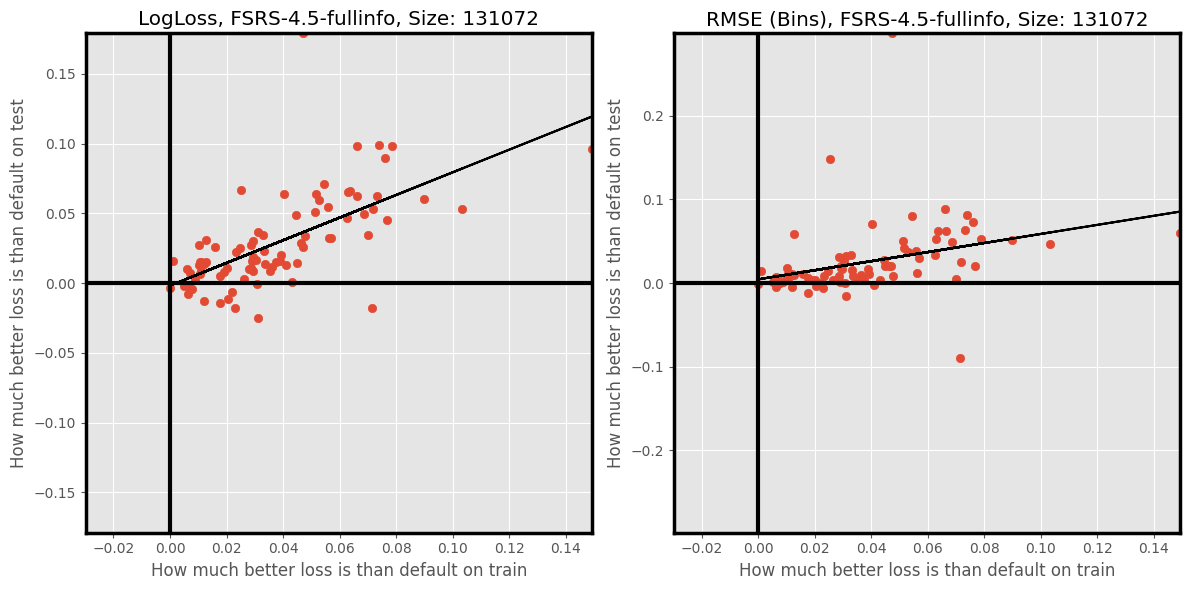

In [253]:
# For each model in [FSRS-4.5-fullinfo, FSRS-4.5-pretrain-fullinfo], compare to model0=FSRS-4.5-dry-run-fullinfo by plotting, for each size:
# X-axis: model_train_loss - model0_train_loss
# Y-axis: model_loss - model0_loss
print("""
For the graphs below:
X-axis: How much better the loss is than default on train
Y-axis: How much better the loss is than default on test

Top right: The optimised model is better on train and test
Bottom right: The optimised model is better on train but worse on test
Top left: The optimised model is worse on train but better on test
Bottom left: The optimised model is worse on train and test
""")
model0_index = 1
model_indexes = [0]#, 2]  # Model 2 (pretrain) is currently approximately the same as model 0 (full train)
for size in unique_sizes:
    for model_index in model_indexes:
        RMSE_model0_train    = [e for e,s in zip(all_RMSE_train_list[model0_index], all_sizes[model0_index]) if s == size]
        RMSE_model_train     = [e for e,s in zip(all_RMSE_train_list[model_index],  all_sizes[model_index])  if s == size]
        RMSE_model0          = [e for e,s in zip(all_RMSE_list[model0_index],       all_sizes[model0_index]) if s == size]
        RMSE_model           = [e for e,s in zip(all_RMSE_list[model_index],        all_sizes[model_index])  if s == size]
        LogLoss_model0_train = [e for e,s in zip(all_RMSE_train_list[model0_index], all_sizes[model0_index]) if s == size]
        LogLoss_model_train  = [e for e,s in zip(all_RMSE_train_list[model_index],  all_sizes[model_index])  if s == size]
        LogLoss_model0       = [e for e,s in zip(all_LogLoss_list[model0_index],    all_sizes[model0_index]) if s == size]
        LogLoss_model        = [e for e,s in zip(all_LogLoss_list[model_index],     all_sizes[model_index])  if s == size]

        # Must be at least 50 samples for each model
        if len(RMSE_model0_train) < 50 or len(RMSE_model) < 50:
            continue
        num_pts = min(len(RMSE_model0_train), len(RMSE_model_train), len(RMSE_model0), len(RMSE_model))
        RMSE_model0_train = RMSE_model0_train[:num_pts]
        RMSE_model_train = RMSE_model_train[:num_pts]
        RMSE_model0 = RMSE_model0[:num_pts]
        RMSE_model = RMSE_model[:num_pts]
        LogLoss_model0_train = LogLoss_model0_train[:num_pts]
        LogLoss_model_train = LogLoss_model_train[:num_pts]
        LogLoss_model0 = LogLoss_model0[:num_pts]
        LogLoss_model = LogLoss_model[:num_pts]

        # Scatter plot (lower loss is better)
        # X-axis: model0_train_loss - model_train_loss
        # Y-axis: model0_loss - model_loss
        fig = plt.figure(figsize=(12, 6))
        ax1 = fig.add_subplot(121)
        ax2 = fig.add_subplot(122)
        RMSE_x = np.array(RMSE_model0_train) - np.array(RMSE_model_train)
        RMSE_y = np.array(RMSE_model0) - np.array(RMSE_model)
        LogLoss_x = np.array(LogLoss_model0_train) - np.array(LogLoss_model_train)
        LogLoss_y = np.array(LogLoss_model0) - np.array(LogLoss_model)
        ax1.scatter(RMSE_x, RMSE_y)
        ax2.scatter(LogLoss_x, LogLoss_y)

        # Regression line
        # ax1.plot(np.unique(RMSE_x), np.poly1d(np.polyfit(RMSE_x, RMSE_y, 1))(np.unique(RMSE_x)), color="black")
        # ax2.plot(np.unique(LogLoss_x), np.poly1d(np.polyfit(LogLoss_x, LogLoss_y, 1))(np.unique(LogLoss_x)), color="black")

        # Regression line through (0,0)
        A = np.vstack([RMSE_x, np.ones(len(RMSE_x))]).T
        m, c = np.linalg.lstsq(A, RMSE_y, rcond=None)[0]
        ax1.plot(RMSE_x, m*RMSE_x + c, color="black")
        A = np.vstack([LogLoss_x, np.ones(len(LogLoss_x))]).T
        m, c = np.linalg.lstsq(A, LogLoss_y, rcond=None)[0]
        ax2.plot(LogLoss_x, m*LogLoss_x + c, color="black")
        

        # Format and display
        ax1.set_title(f"LogLoss, {models[model_index]}, Size: {size}")
        ax2.set_title(f"RMSE (Bins), {models[model_index]}, Size: {size}")
        ax1.set_xlabel(f"How much better loss is than default on train")
        ax1.set_ylabel(f"How much better loss is than default on test")
        ax2.set_xlabel(f"How much better loss is than default on train")
        ax2.set_ylabel(f"How much better loss is than default on test")
        # Centre (0,0)
        rmse_x_max_abs = np.abs(RMSE_x).max()
        rmse_y_max_abs = np.abs(RMSE_y).max()
        logloss_x_max_abs = np.abs(LogLoss_x).max()
        logloss_y_max_abs = np.abs(LogLoss_y).max()
        ax1.set_xlim(-rmse_x_max_abs/5, rmse_x_max_abs)
        ax1.set_ylim(-rmse_y_max_abs, rmse_y_max_abs)
        ax2.set_xlim(-logloss_x_max_abs/5, logloss_x_max_abs)
        ax2.set_ylim(-logloss_y_max_abs, logloss_y_max_abs)
        # Add border
        for ax in [ax1, ax2]:
            ax.spines["top"].set_linewidth(2.5)
            ax.spines["top"].set_color("black")
            ax.spines["bottom"].set_linewidth(2.5)
            ax.spines["bottom"].set_color("black")
            ax.spines["left"].set_linewidth(2.5)
            ax.spines["left"].set_color("black")
            ax.spines["right"].set_linewidth(2.5)
            ax.spines["right"].set_color("black")
        # Add cross
        for ax in [ax1, ax2]:
            ax.axhline(0, color="black", linewidth=3)
            ax.axvline(0, color="black", linewidth=3)
        plt.tight_layout()
        plt.show()

    #     # Plot train against test for the optimised model
    #     fig = plt.figure(figsize=(12, 6))
    #     ax1 = fig.add_subplot(121)
    #     ax2 = fig.add_subplot(122)
    #     ax1.scatter(RMSE_model_train, RMSE_model)
    #     ax2.scatter(LogLoss_model_train, LogLoss_model)
    #     ax1.set_title(f"LogLoss, {models[model_index]}, Size: {size}")
    #     ax2.set_title(f"RMSE (Bins), {models[model_index]}, Size: {size}")
    #     ax1.set_xlabel(f"Train Loss")
    #     ax1.set_ylabel(f"Test Loss")
    #     ax2.set_xlabel(f"Train Loss")
    #     ax2.set_ylabel(f"Test Loss")
    #     plt.tight_layout()
    #     plt.show()
    
    # # Plot train against test for the default model
    # fig = plt.figure(figsize=(12, 6))
    # ax1 = fig.add_subplot(121)
    # ax2 = fig.add_subplot(122)
    # ax1.scatter(RMSE_model0_train, RMSE_model0)
    # ax2.scatter(LogLoss_model0_train, LogLoss_model0)
    # ax1.set_title(f"LogLoss, {models[model0_index]}, Size: {size}")
    # ax2.set_title(f"RMSE (Bins), {models[model0_index]}, Size: {size}")
    # ax1.set_xlabel(f"Train Loss")
    # ax1.set_ylabel(f"Test Loss")
    # ax2.set_xlabel(f"Train Loss")
    # ax2.set_ylabel(f"Test Loss")
    # plt.tight_layout()
    # plt.show()

    

Check relationship between pretrain (optimise first 4 parameters only, with L1 loss) and full train


<Figure size 1200x600 with 0 Axes>

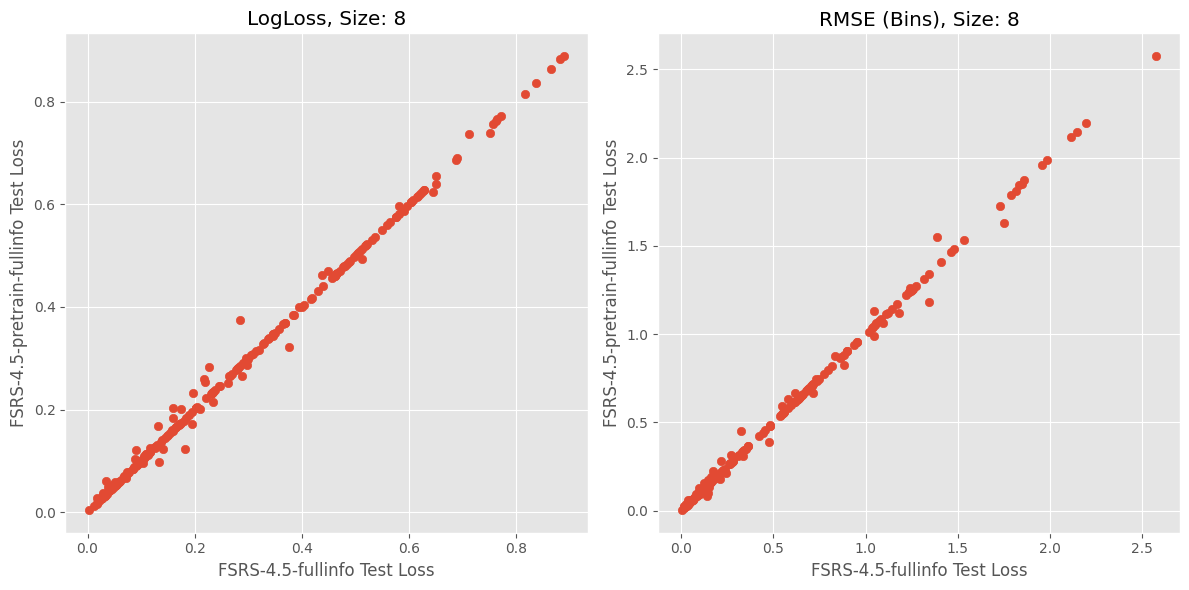

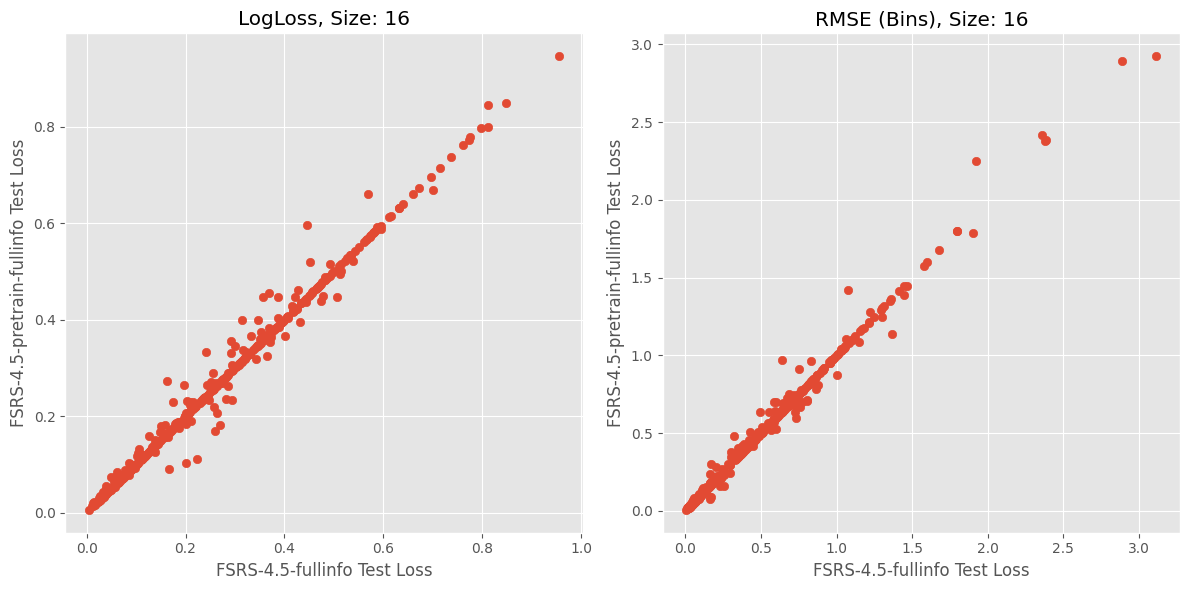

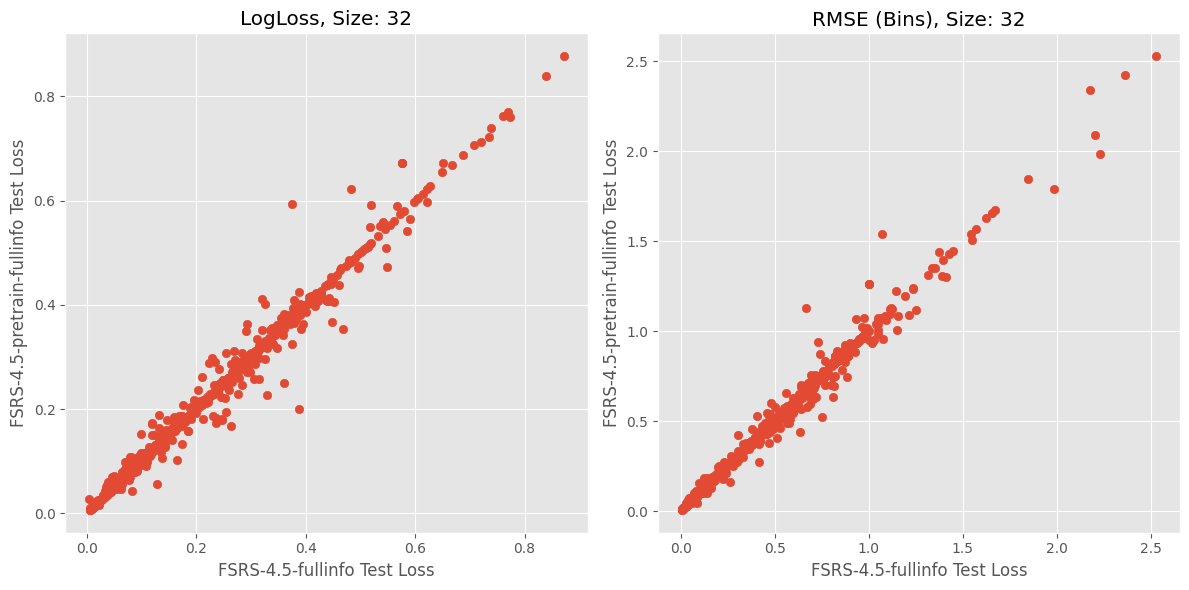

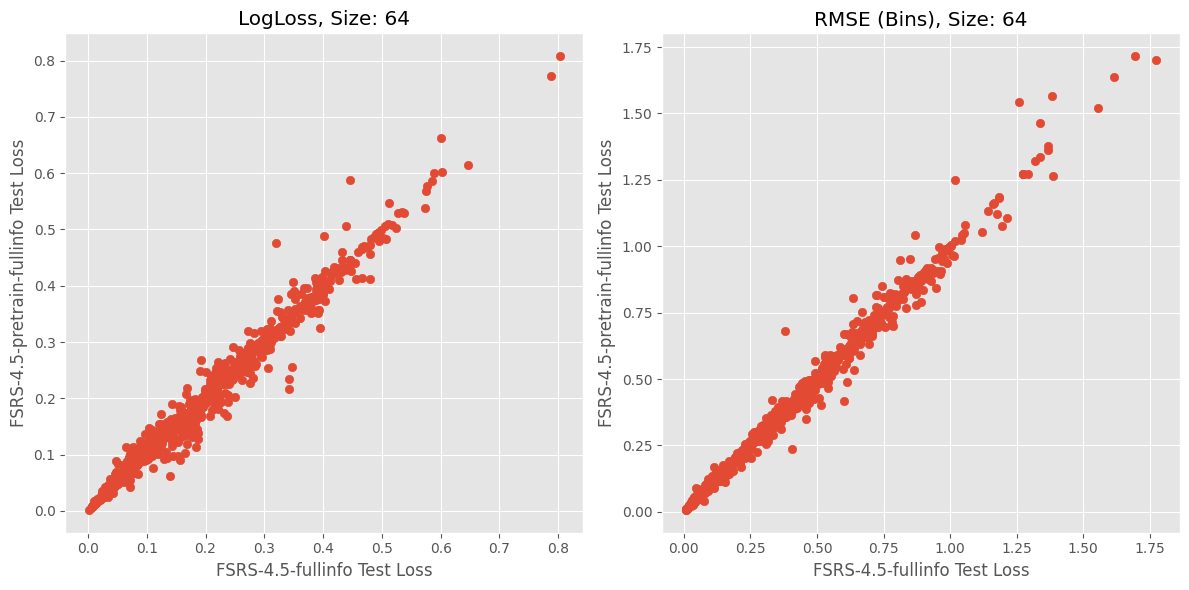

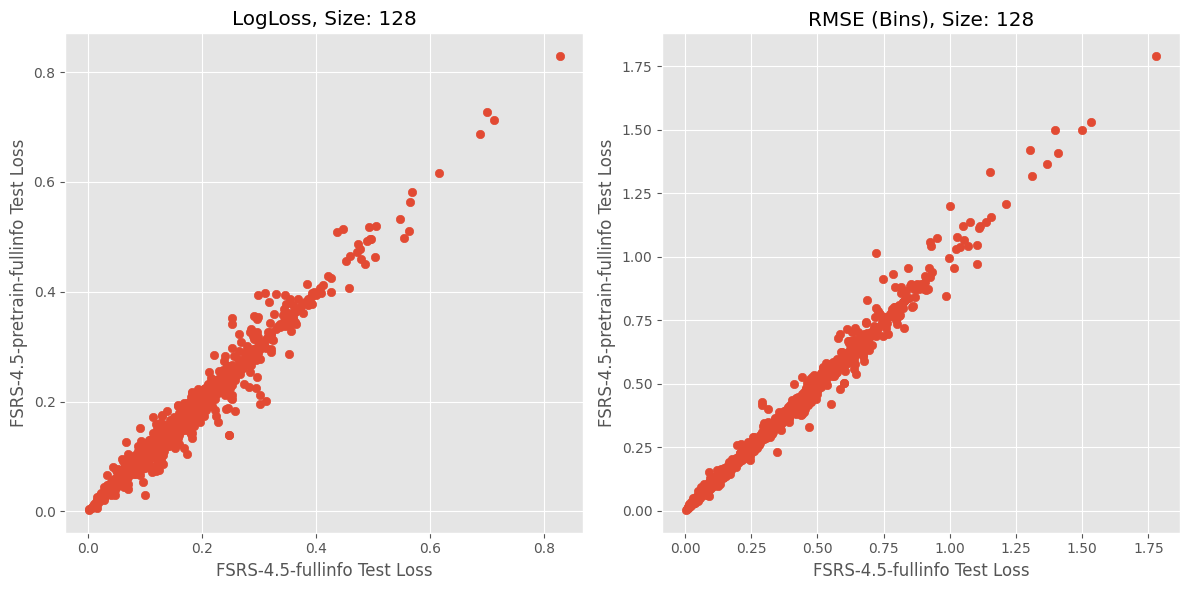

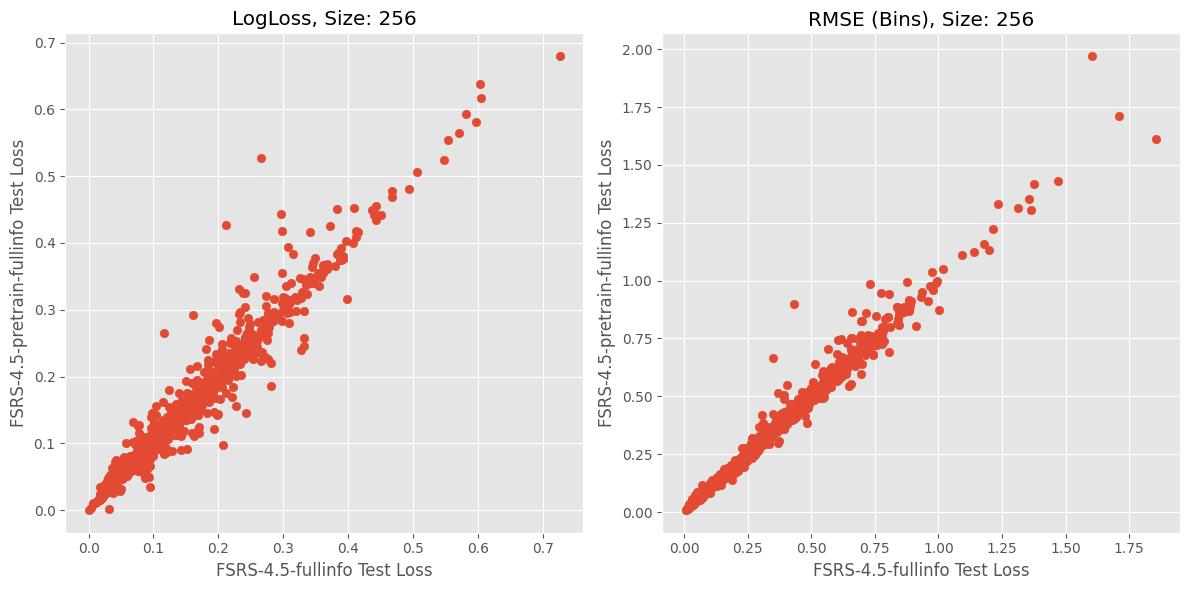

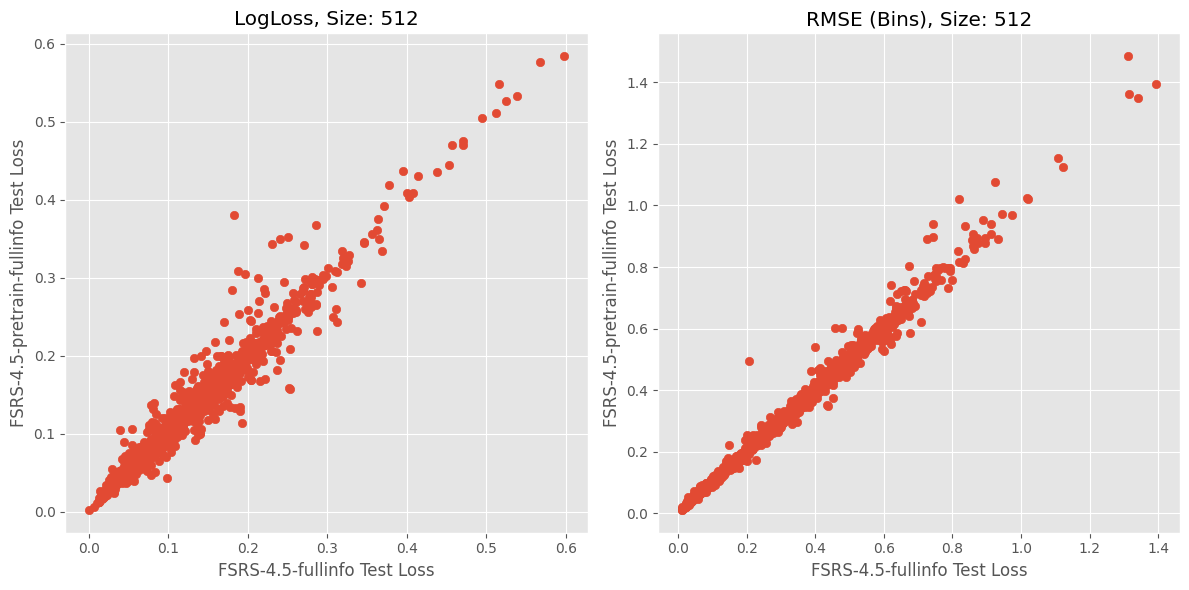

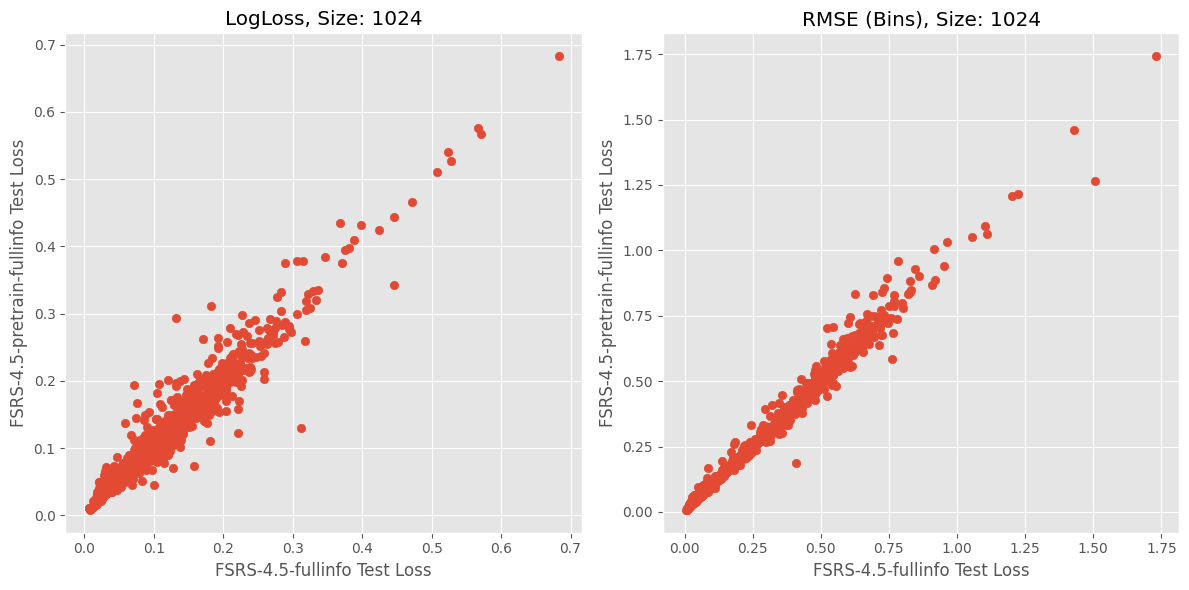

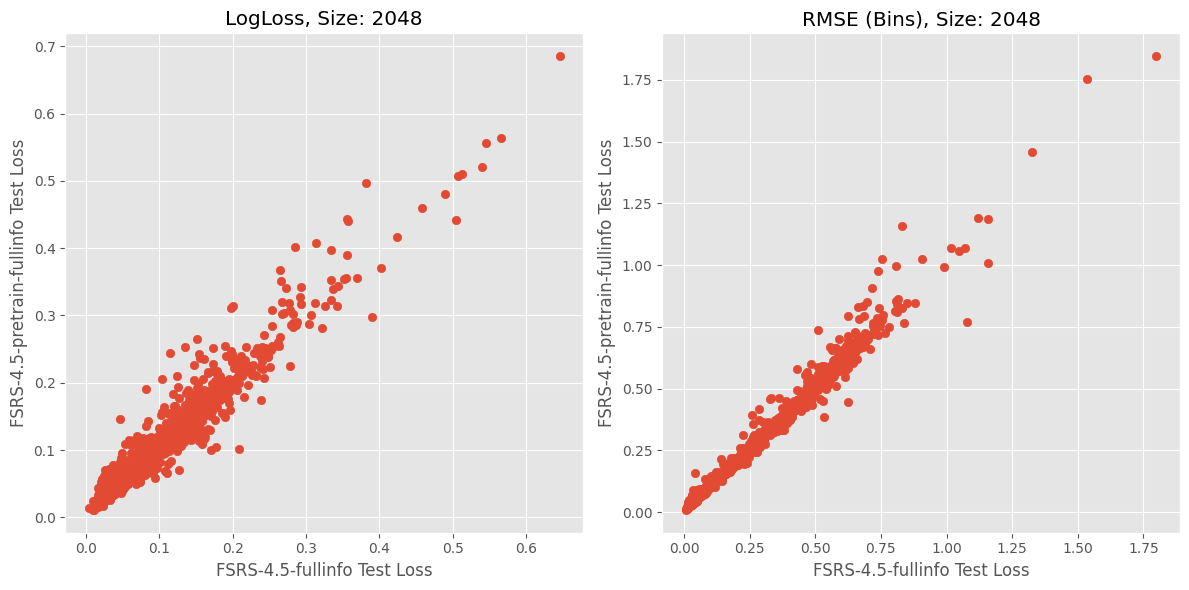

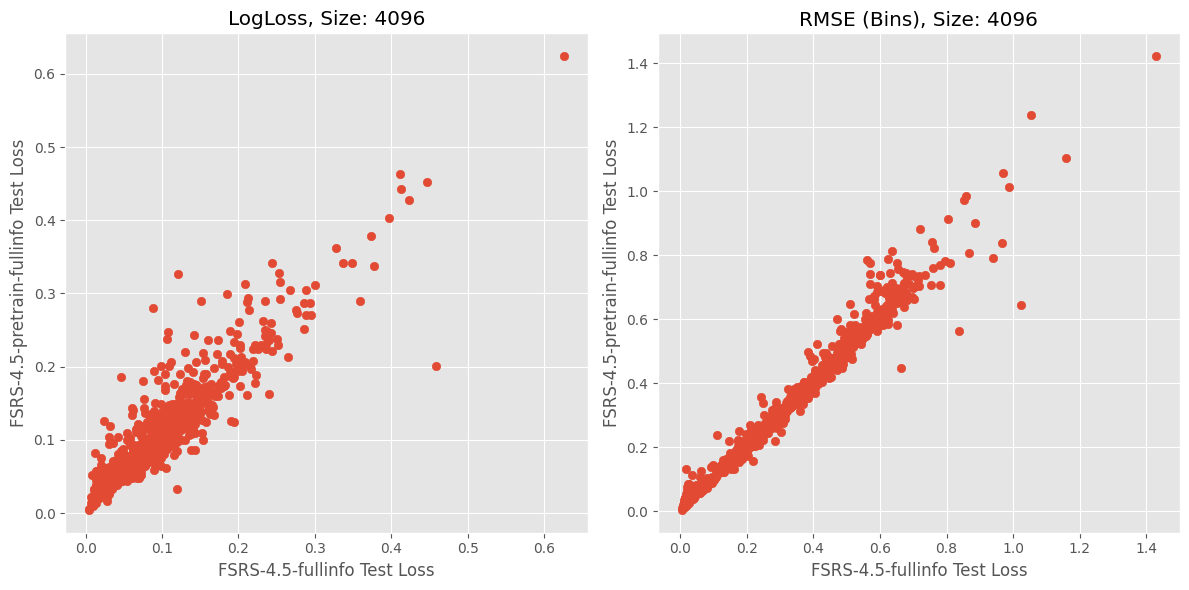

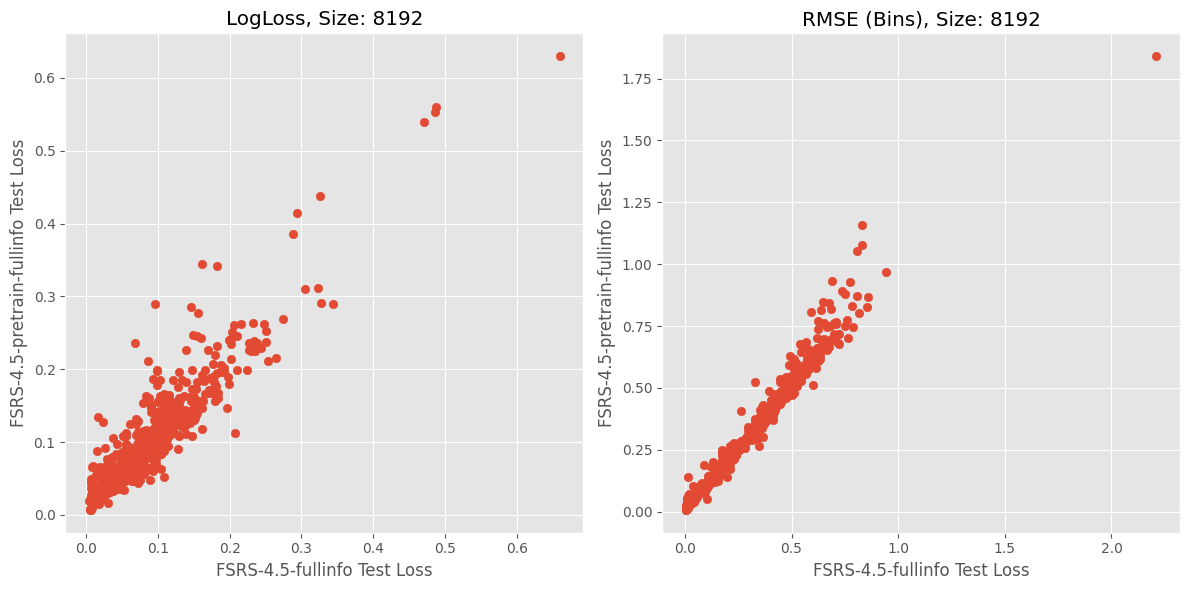

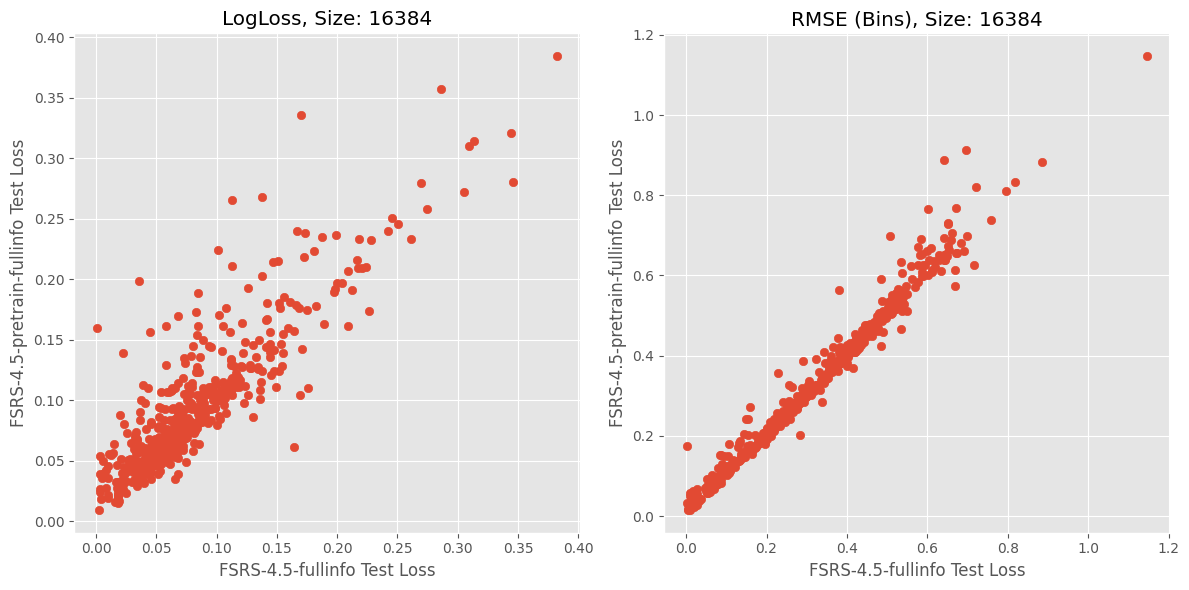

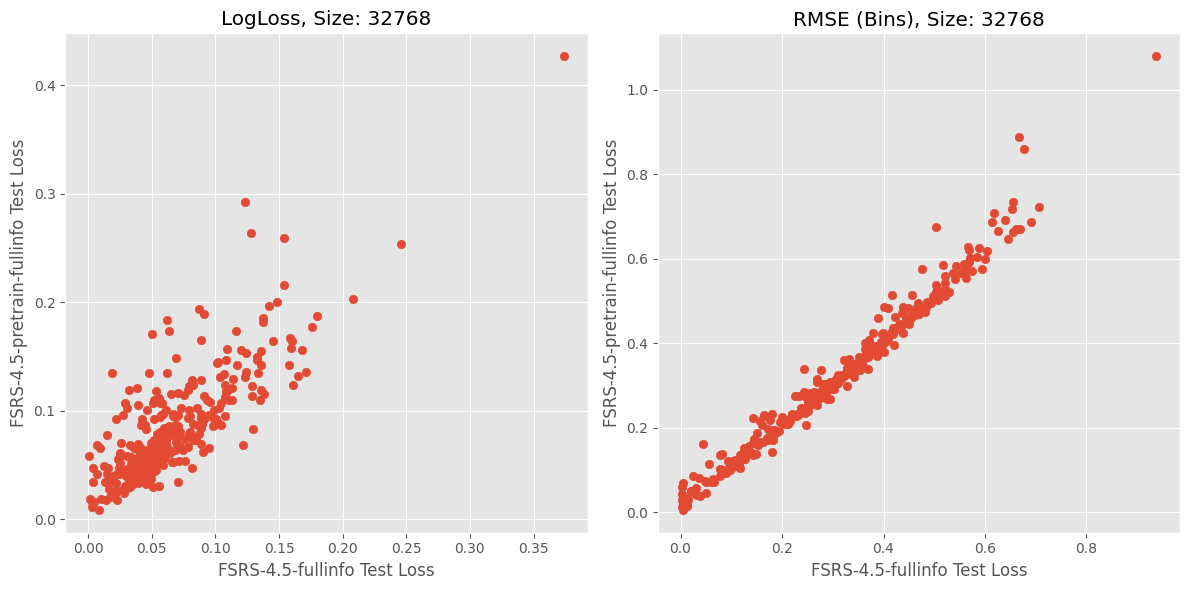

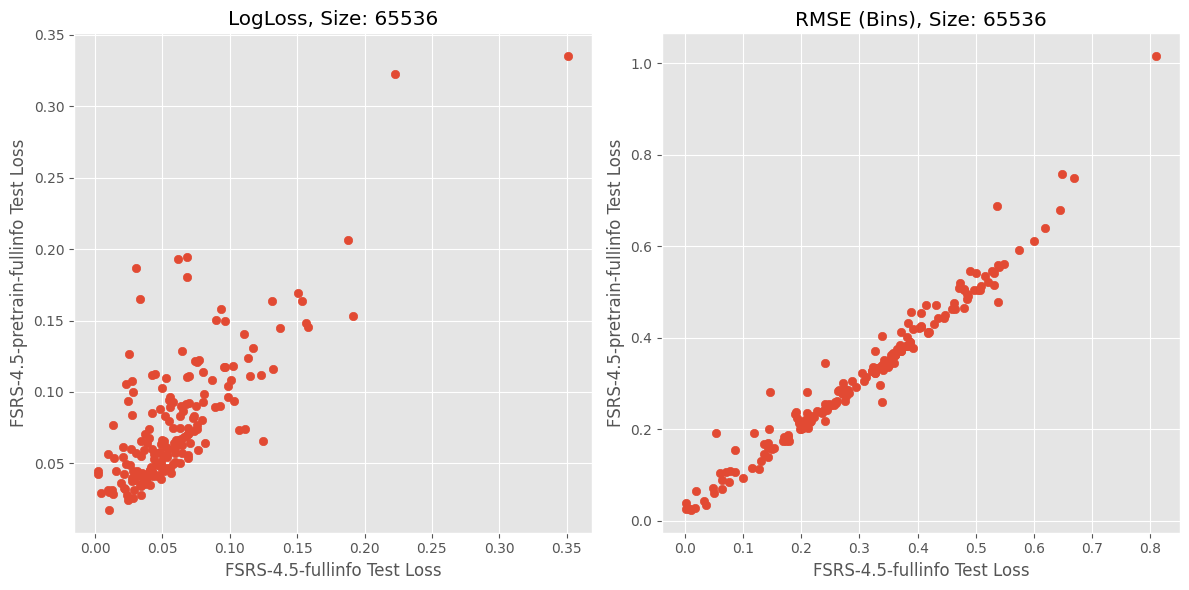

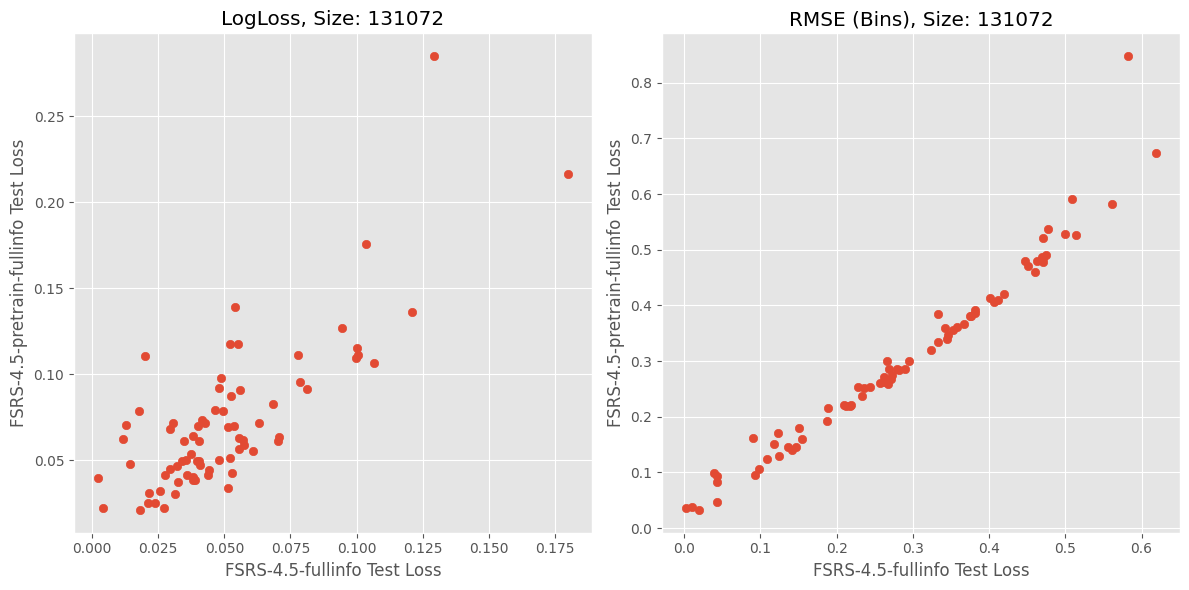

In [232]:
print("Check relationship between pretrain (optimise first 4 parameters only, with L1 loss) and full train")
# Plot model[2] on y and model[0] on x
plt.figure(figsize=(12, 6))
for size in unique_sizes:
    RMSE_model0_train = [e for e,s in zip(all_RMSE_train_list[0], all_sizes[0]) if s == size]
    RMSE_model_train = [e for e,s in zip(all_RMSE_train_list[2], all_sizes[2]) if s == size]
    RMSE_model0 = [e for e,s in zip(all_RMSE_list[0], all_sizes[0]) if s == size]
    RMSE_model = [e for e,s in zip(all_RMSE_list[2], all_sizes[2]) if s == size]
    LogLoss_model0_train = [e for e,s in zip(all_RMSE_train_list[0], all_sizes[0]) if s == size]
    LogLoss_model_train = [e for e,s in zip(all_RMSE_train_list[2], all_sizes[2]) if s == size]
    LogLoss_model0 = [e for e,s in zip(all_LogLoss_list[0], all_sizes[0]) if s == size]
    LogLoss_model = [e for e,s in zip(all_LogLoss_list[2], all_sizes[2]) if s == size]

    # Must be at least 50 samples for each model
    if len(RMSE_model0_train) < 50 or len(RMSE_model) < 50:
        continue
    num_pts = min(len(RMSE_model0_train), len(RMSE_model_train), len(RMSE_model0), len(RMSE_model))
    RMSE_model0_train = RMSE_model0_train[:num_pts]
    RMSE_model_train = RMSE_model_train[:num_pts]
    RMSE_model0 = RMSE_model0[:num_pts]
    RMSE_model = RMSE_model[:num_pts]
    LogLoss_model0_train = LogLoss_model0_train[:num_pts]
    LogLoss_model_train = LogLoss_model_train[:num_pts]
    LogLoss_model0 = LogLoss_model0[:num_pts]
    LogLoss_model = LogLoss_model[:num_pts]

    # Scatter plot
    # model[2] on y and model[0] on x
    fig = plt.figure(figsize=(12, 6))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    ax1.scatter(RMSE_model0, RMSE_model)
    ax2.scatter(LogLoss_model0, LogLoss_model)
    ax1.set_title(f"LogLoss, Size: {size}")
    ax2.set_title(f"RMSE (Bins), Size: {size}")
    ax1.set_xlabel(f"{models[0]} Test Loss")
    ax1.set_ylabel(f"{models[2]} Test Loss")
    ax2.set_xlabel(f"{models[0]} Test Loss")
    ax2.set_ylabel(f"{models[2]} Test Loss")
    plt.tight_layout()
    plt.show()